<a href="https://colab.research.google.com/github/AkshatJain0707/Adinath-Filtech/blob/main/Agilisium_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels \
            pydeseq2 gseapy openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install pydeseq2 gseapy


In [11]:
!pip install -q "pydeseq2==0.4.7" gseapy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00


In [16]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
GSE123966 – IMMUNE CELL DIFFERENTIATION ANALYSIS
PRODUCTION-GRADE BIOINFORMATICS PIPELINE v5.2 (COMPLETELY FIXED)
T Cell Lineage Commitment (Naive → Th1 / Th2)
"""

from pathlib import Path
from typing import Tuple, List, Dict
import re
import sys
import warnings
import logging
from datetime import datetime

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp

warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ════════════════════════════════════════════════════════════════════════════
#  LOGGING
# ════════════════════════════════════════════════════════════════════════════

def setup_logging(output_dir: Path):
    log_file = output_dir / 'analysis.log'
    logger = logging.getLogger('GSE123966')
    logger.setLevel(logging.DEBUG)
    logger.handlers.clear()

    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.INFO)
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.DEBUG)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)-8s | %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    ch.setFormatter(formatter)
    fh.setFormatter(formatter)

    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger

# ════════════════════════════════════════════════════════════════════════════
#  CONFIG
# ════════════════════════════════════════════════════════════════════════════

class PipelineConfig:
    COUNTS_FILE = Path("/content/drive/MyDrive/Agilisium case study dataset/case study.xlsx")
    OUTPUT_DIR = Path("gse123966_results")
    USE_WT_ONLY = True
    MIN_COUNTS_PER_GENE = 10
    ALPHA_FDR = 0.01
    LFC_THRESHOLD = 1.0
    T_TEST_EQUAL_VAR = False
    MIN_GENES_FOR_ENRICHMENT = 5
    ENRICHMENT_P_CUTOFF = 0.05
    TOP_N_ENRICHMENT_TERMS = 20
    DPI = 300
    TOP_N_DEG_HEATMAP = 50
    HEATMAP_CMAP = 'RdBu_r'
    PCA_FIGSIZE = (7, 6)
    HEATMAP_FONT_SIZE = 8
    ENRICHMENT_LIBRARIES = ['GO_Biological_Process_2023']  # REMOVED KEGG (unreliable)

    @classmethod
    def validate_and_prepare(cls, logger):
        logger.info("="*80)
        logger.info("VALIDATING PIPELINE CONFIGURATION")
        logger.info("="*80)
        if not cls.COUNTS_FILE.exists():
            logger.error(f"ERROR: Counts file not found: {cls.COUNTS_FILE}")
            raise FileNotFoundError(f"File not found: {cls.COUNTS_FILE}")
        cls.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        logger.info(f"✓ Input file: {cls.COUNTS_FILE}")
        logger.info(f"✓ Output directory: {cls.OUTPUT_DIR.resolve()}")
        logger.info(f"✓ FDR threshold: {cls.ALPHA_FDR}")
        logger.info("✓ Configuration validated\n")

# ════════════════════════════════════════════════════════════════════════════
#  DATA LOADING
# ════════════════════════════════════════════════════════════════════════════

class DataLoader:
    @staticmethod
    def load_counts_and_annotation(path: Path, logger):
        logger.info("STEP 1: LOADING DATA")
        logger.info("-"*80)
        suffix = path.suffix.lower()
        logger.info(f"Reading {suffix} file...")

        try:
            if suffix in ['.xlsx', '.xls']:
                df = pd.read_excel(path)
            elif suffix == '.csv':
                df = pd.read_csv(path)
            elif suffix in ['.tsv', '.txt']:
                df = pd.read_csv(path, sep='\t')
            else:
                raise ValueError(f"Unsupported file format: {suffix}")
        except Exception as e:
            logger.error(f"ERROR reading file: {e}")
            raise

        df.columns = [c.strip().replace(' ', '.') for c in df.columns]
        annot_cols = ['Gene.ID', 'Chrom', 'Gene..Name', 'Biotype']

        if not all(c in df.columns for c in annot_cols):
            logger.error(f"Missing required columns")
            raise ValueError(f"Missing required columns")

        logger.info(f"✓ Found required annotation columns")

        annot = df[annot_cols].copy().rename(columns={
            'Gene.ID': 'gene_id',
            'Chrom': 'chrom',
            'Gene..Name': 'gene_name',
            'Biotype': 'biotype'
        })

        # CRITICAL FIX: Convert gene_name to string (handle datetime objects)
        annot['gene_name'] = annot['gene_name'].astype(str).str.strip()

        counts = df.drop(columns=annot_cols).copy()
        counts = counts.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

        counts.index = annot['gene_id'].values
        annot.index = annot['gene_id'].values

        logger.info(f"✓ Loaded {len(counts)} genes × {counts.shape[1]} samples")
        logger.info(f"✓ Count range: [{counts.min().min()}, {counts.max().max()}]")
        logger.info(f"✓ Indices aligned\n")

        return counts, annot

    @staticmethod
    def extract_metadata_from_sample_ids(sample_ids: List[str], logger):
        logger.info("Extracting metadata from sample IDs...")
        metadata_list = []

        for sample_id in sample_ids:
            if 'Th1' in sample_id:
                condition = 'Th1'
            elif 'Th2' in sample_id:
                condition = 'Th2'
            elif re.search(r'-S\d+$', sample_id):
                condition = 'Naive'
            else:
                raise ValueError(f"Unrecognized sample ID: {sample_id}")

            genotype = 'WT' if sample_id.startswith('W') else 'KO' if sample_id.startswith('K') else None
            if not genotype:
                raise ValueError(f"Unrecognized genotype in: {sample_id}")

            metadata_list.append({'sample_id': sample_id, 'condition': condition, 'genotype': genotype})

        meta = pd.DataFrame(metadata_list)
        meta['condition'] = pd.Categorical(meta['condition'], categories=['Naive', 'Th1', 'Th2'], ordered=True)
        meta['genotype'] = pd.Categorical(meta['genotype'], categories=['WT', 'KO'], ordered=False)
        meta = meta.set_index('sample_id')

        logger.info(f"✓ Extracted metadata for {len(meta)} samples\n")
        return meta

# ════════════════════════════════════════════════════════════════════════════
#  QC
# ════════════════════════════════════════════════════════════════════════════

class QualityControl:
    @staticmethod
    def filter_samples_and_genes(counts, annot, meta, logger):
        logger.info("STEP 2: QUALITY CONTROL & FILTERING")
        logger.info("-"*80)

        if PipelineConfig.USE_WT_ONLY:
            wt_samples = meta[meta['genotype'] == 'WT'].index.tolist()
            counts = counts[wt_samples]
            meta = meta.loc[wt_samples]
            logger.info(f"✓ Filtered to WT only: {len(wt_samples)} samples")

        keep_genes = counts.sum(axis=1) >= PipelineConfig.MIN_COUNTS_PER_GENE
        counts = counts[keep_genes]
        annot = annot[keep_genes]

        logger.info(f"✓ Removed {(~keep_genes).sum()} low-count genes")
        logger.info(f"✓ Retained: {len(counts)} genes\n")

        return counts, annot, meta

# ════════════════════════════════════════════════════════════════════════════
#  NORMALIZATION
# ════════════════════════════════════════════════════════════════════════════

class Normalization:
    @staticmethod
    def normalize_to_log_cpm(counts, logger):
        logger.info("STEP 3: NORMALIZATION")
        logger.info("-"*80)

        lib_size = counts.sum(axis=0)
        cpm = counts.div(lib_size, axis=1) * 1e6
        log_cpm = np.log2(cpm + 1)

        logger.info(f"✓ Normalized to CPM and log2-transformed\n")
        return log_cpm

# ════════════════════════════════════════════════════════════════════════════
#  PCA
# ════════════════════════════════════════════════════════════════════════════

class PCAAnalysis:
    @staticmethod
    def run_pca_and_plot(expr_log, meta, output_path, logger):
        logger.info("STEP 4: PRINCIPAL COMPONENT ANALYSIS")
        logger.info("-"*80)

        scaler = StandardScaler()
        expr_scaled = scaler.fit_transform(expr_log.T)
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(expr_scaled)
        var_exp = pca.explained_variance_ratio_ * 100

        logger.info(f"✓ PCA variance: PC1={var_exp[0]:.1f}%, PC2={var_exp[1]:.1f}%")

        pca_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=expr_log.columns).join(meta)

        fig, ax = plt.subplots(figsize=PipelineConfig.PCA_FIGSIZE, dpi=72)
        colors = {'Naive': '#1f77b4', 'Th1': '#ff7f0e', 'Th2': '#2ca02c'}

        for condition in ['Naive', 'Th1', 'Th2']:
            mask = pca_df['condition'] == condition
            ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], label=condition, s=150, alpha=0.8, color=colors[condition], edgecolors='black', linewidth=1)

        ax.set_xlabel(f"PC1 ({var_exp[0]:.1f}%)", fontsize=12, fontweight='bold')
        ax.set_ylabel(f"PC2 ({var_exp[1]:.1f}%)", fontsize=12, fontweight='bold')
        ax.set_title('PCA: Naive vs Th1 vs Th2 (WT only)', fontsize=13, fontweight='bold')
        ax.legend(title='Condition', frameon=True, fontsize=11)
        ax.grid(True, alpha=0.3)

        fig.tight_layout()
        fig.savefig(output_path, dpi=PipelineConfig.DPI, bbox_inches='tight')
        plt.close()

        logger.info(f"✓ PCA plot saved: {output_path}\n")
        return {'pca': pca, 'coords': pca_df, 'var': var_exp}

# ════════════════════════════════════════════════════════════════════════════
#  DE
# ════════════════════════════════════════════════════════════════════════════

class DifferentialExpression:
    @staticmethod
    def compute_de_contrast(expr_log, meta, annot, contrast_level, control_level, label, logger):
        logger.info(f"Computing DE: {contrast_level} vs {control_level}...")

        idx_contrast = meta['condition'] == contrast_level
        idx_control = meta['condition'] == control_level

        expr_contrast = expr_log.loc[:, idx_contrast]
        expr_control = expr_log.loc[:, idx_control]

        results = []
        for gene_id in expr_log.index:
            x1 = expr_contrast.loc[gene_id].values
            x2 = expr_control.loc[gene_id].values
            mean1, mean2 = x1.mean(), x2.mean()
            t_stat, p_val = stats.ttest_ind(x1, x2, equal_var=False, nan_policy='omit')
            if np.isnan(p_val):
                p_val = 1.0
            results.append({'gene_id': gene_id, 'log2FoldChange': mean1 - mean2, 'pvalue': p_val})

        res_df = pd.DataFrame(results)
        res_df['padj'] = multipletests(res_df['pvalue'], method='fdr_bh')[1]
        all_genes = res_df.merge(annot.reset_index(), on='gene_id', how='left')

        degs = all_genes[(all_genes['padj'] < PipelineConfig.ALPHA_FDR) & (all_genes['log2FoldChange'].abs() >= PipelineConfig.LFC_THRESHOLD)].copy()

        all_genes.to_csv(PipelineConfig.OUTPUT_DIR / f'DE_all_genes_{label}.csv', index=False)
        degs.to_csv(PipelineConfig.OUTPUT_DIR / f'DE_DEGs_{label}.csv', index=False)

        logger.info(f"✓ {label}: {len(degs)} DEGs (↑{(degs['log2FoldChange']>0).sum()} ↓{(degs['log2FoldChange']<0).sum()})\n")

        return all_genes, degs

# ════════════════════════════════════════════════════════════════════════════
#  VIZ
# ════════════════════════════════════════════════════════════════════════════

class Visualization:
    @staticmethod
    def plot_heatmap_degs(expr_log, degs, meta, label, logger):
        if len(degs) == 0:
            logger.warning(f"No DEGs for {label}")
            return

        top_n = min(PipelineConfig.TOP_N_DEG_HEATMAP, len(degs))
        top_genes = [g for g in degs.nsmallest(top_n, 'padj')['gene_id'].tolist() if g in expr_log.index]

        if not top_genes:
            return

        mat = expr_log.loc[top_genes].copy()
        mat_z = mat.sub(mat.mean(axis=1), axis=0).div(mat.std(axis=1) + 1e-8, axis=0)

        fig, ax = plt.subplots(figsize=(10, max(8, 0.15 * len(top_genes))), dpi=72)
        sns.heatmap(mat_z, cmap='RdBu_r', center=0, vmin=-2, vmax=2, cbar_kws={'label': 'Z-score'}, ax=ax)
        ax.set_title(f'Top {len(top_genes)} DE Genes: {label}', fontsize=13, fontweight='bold')
        ax.set_xlabel('Sample', fontsize=11, fontweight='bold')
        ax.set_ylabel('Gene', fontsize=11, fontweight='bold')

        fig.tight_layout()
        fig.savefig(PipelineConfig.OUTPUT_DIR / f'heatmap_DEGs_{label}.png', dpi=PipelineConfig.DPI, bbox_inches='tight')
        plt.close()
        logger.info(f"✓ Heatmap: {label}")

# ════════════════════════════════════════════════════════════════════════════
#  ENRICH (FIXED - ROBUST ERROR HANDLING)
# ════════════════════════════════════════════════════════════════════════════

class PathwayEnrichment:
    @staticmethod
    def run_enrichment(degs, label, logger):
        if len(degs) == 0:
            return

        # CRITICAL FIX: Convert gene_name to strings properly
        try:
            genes_raw = degs['gene_name'].dropna().tolist()
            genes = []

            for g in genes_raw:
                try:
                    # Convert to string and strip
                    g_str = str(g).strip()
                    # Skip if empty or 'nan' or contains non-alphanumeric
                    if g_str and g_str.lower() != 'nan' and len(g_str) > 0:
                        genes.append(g_str)
                except:
                    continue

            genes = list(set(genes))  # Remove duplicates

        except Exception as e:
            logger.warning(f"Error extracting genes for {label}: {e}")
            return

        if len(genes) < PipelineConfig.MIN_GENES_FOR_ENRICHMENT:
            logger.info(f"Too few valid genes for {label} ({len(genes)}); skipping enrichment")
            return

        logger.info(f"Enrichment: {label} ({len(genes)} genes)...")

        for lib in PipelineConfig.ENRICHMENT_LIBRARIES:
            try:
                logger.info(f"  Testing library: {lib}...")

                enr = gp.enrichr(
                    gene_list=genes,
                    gene_sets=[lib],
                    organism='Mouse',
                    outdir=None,
                    cutoff=0.05
                )

                if enr is None or not hasattr(enr, 'results') or enr.results is None or len(enr.results) == 0:
                    logger.info(f"    No terms found for {lib}")
                    continue

                res = enr.results.copy()
                csv_path = PipelineConfig.OUTPUT_DIR / f'enrichment_{label}_{lib}.csv'
                res.to_csv(csv_path, index=False)
                logger.info(f"    ✓ {len(res)} terms | Saved: {csv_path}")

                # Plot
                top_n = min(PipelineConfig.TOP_N_ENRICHMENT_TERMS, len(res))
                top = res.nsmallest(top_n, 'Adjusted P-value')

                fig, ax = plt.subplots(figsize=(10, max(6, 0.3 * top_n)), dpi=72)
                top_sorted = top.sort_values('Combined Score')
                ax.barh(top_sorted['Term'], top_sorted['Combined Score'], color='#4c72b0')
                ax.set_xlabel('Combined Score', fontsize=11, fontweight='bold')
                ax.set_title(f'{label} - {lib}', fontsize=12, fontweight='bold')

                fig.tight_layout()
                png_path = PipelineConfig.OUTPUT_DIR / f'enrichment_{label}_{lib}.png'
                fig.savefig(png_path, dpi=PipelineConfig.DPI, bbox_inches='tight')
                plt.close()
                logger.info(f"    ✓ Plot: {png_path}")

            except Exception as e:
                logger.info(f"    Skipped {lib}: {type(e).__name__}")
                continue

# ════════════════════════════════════════════════════════════════════════════
#  MAIN
# ════════════════════════════════════════════════════════════════════════════

def main():
    print("\n" + "╔" + "="*78 + "╗")
    print("║" + "GSE123966 BIOINFORMATICS PIPELINE v5.2 (FIXED)".center(78) + "║")
    print("║" + "T Cell Differentiation Analysis".center(78) + "║")
    print("╚" + "="*78 + "╝\n")

    PipelineConfig.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    logger = setup_logging(PipelineConfig.OUTPUT_DIR)

    logger.info("PIPELINE START")

    try:
        PipelineConfig.validate_and_prepare(logger)
        counts, annot = DataLoader.load_counts_and_annotation(PipelineConfig.COUNTS_FILE, logger)
        meta = DataLoader.extract_metadata_from_sample_ids(counts.columns.tolist(), logger)
        counts, annot, meta = QualityControl.filter_samples_and_genes(counts, annot, meta, logger)
        expr_log = Normalization.normalize_to_log_cpm(counts, logger)
        PCAAnalysis.run_pca_and_plot(expr_log, meta, PipelineConfig.OUTPUT_DIR / '01_PCA_samples.png', logger)

        logger.info("STEP 5: DIFFERENTIAL EXPRESSION")
        logger.info("-"*80)
        all_th1, degs_th1 = DifferentialExpression.compute_de_contrast(expr_log, meta, annot, 'Th1', 'Naive', 'Th1_vs_Naive', logger)
        all_th2, degs_th2 = DifferentialExpression.compute_de_contrast(expr_log, meta, annot, 'Th2', 'Naive', 'Th2_vs_Naive', logger)

        logger.info("STEP 6: HEATMAPS")
        logger.info("-"*80)
        Visualization.plot_heatmap_degs(expr_log, degs_th1, meta, 'Th1_vs_Naive', logger)
        Visualization.plot_heatmap_degs(expr_log, degs_th2, meta, 'Th2_vs_Naive', logger)
        logger.info("")

        logger.info("STEP 7: ENRICHMENT")
        logger.info("-"*80)
        PathwayEnrichment.run_enrichment(degs_th1, 'Th1_vs_Naive', logger)
        PathwayEnrichment.run_enrichment(degs_th2, 'Th2_vs_Naive', logger)

        logger.info("="*80)
        logger.info("✓ PIPELINE COMPLETED SUCCESSFULLY")
        logger.info("="*80)
        print("\n✓ ANALYSIS COMPLETE\n")

    except Exception as e:
        logger.error(f"FATAL: {e}", exc_info=True)
        print(f"\n✗ FAILED: {e}\n")
        sys.exit(1)

if __name__ == '__main__':
    main()



╔==============================================================================╗
║                GSE123966 BIOINFORMATICS PIPELINE v5.2 (FIXED)                ║
║                       T Cell Differentiation Analysis                        ║
╚==============================================================================╝

2026-01-03 09:26:28 | GSE123966 | INFO     | PIPELINE START


INFO:GSE123966:PIPELINE START


2026-01-03 09:26:28 | GSE123966 | INFO     | ================================================================================


INFO:GSE123966:================================================================================


2026-01-03 09:26:28 | GSE123966 | INFO     | VALIDATING PIPELINE CONFIGURATION


INFO:GSE123966:VALIDATING PIPELINE CONFIGURATION


2026-01-03 09:26:28 | GSE123966 | INFO     | ================================================================================


INFO:GSE123966:================================================================================


2026-01-03 09:26:28 | GSE123966 | INFO     | ✓ Input file: /content/drive/MyDrive/Agilisium case study dataset/case study.xlsx


INFO:GSE123966:✓ Input file: /content/drive/MyDrive/Agilisium case study dataset/case study.xlsx


2026-01-03 09:26:28 | GSE123966 | INFO     | ✓ Output directory: /content/gse123966_results


INFO:GSE123966:✓ Output directory: /content/gse123966_results


2026-01-03 09:26:28 | GSE123966 | INFO     | ✓ FDR threshold: 0.01


INFO:GSE123966:✓ FDR threshold: 0.01


2026-01-03 09:26:28 | GSE123966 | INFO     | ✓ Configuration validated



INFO:GSE123966:✓ Configuration validated



2026-01-03 09:26:28 | GSE123966 | INFO     | STEP 1: LOADING DATA


INFO:GSE123966:STEP 1: LOADING DATA


2026-01-03 09:26:28 | GSE123966 | INFO     | --------------------------------------------------------------------------------


INFO:GSE123966:--------------------------------------------------------------------------------


2026-01-03 09:26:28 | GSE123966 | INFO     | Reading .xlsx file...


INFO:GSE123966:Reading .xlsx file...


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Found required annotation columns


INFO:GSE123966:✓ Found required annotation columns


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Loaded 22048 genes × 20 samples


INFO:GSE123966:✓ Loaded 22048 genes × 20 samples


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Count range: [0, 231291]


INFO:GSE123966:✓ Count range: [0, 231291]


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Indices aligned



INFO:GSE123966:✓ Indices aligned



2026-01-03 09:26:41 | GSE123966 | INFO     | Extracting metadata from sample IDs...


INFO:GSE123966:Extracting metadata from sample IDs...


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Extracted metadata for 20 samples



INFO:GSE123966:✓ Extracted metadata for 20 samples



2026-01-03 09:26:41 | GSE123966 | INFO     | STEP 2: QUALITY CONTROL & FILTERING


INFO:GSE123966:STEP 2: QUALITY CONTROL & FILTERING


2026-01-03 09:26:41 | GSE123966 | INFO     | --------------------------------------------------------------------------------


INFO:GSE123966:--------------------------------------------------------------------------------


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Filtered to WT only: 14 samples


INFO:GSE123966:✓ Filtered to WT only: 14 samples


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Removed 7618 low-count genes


INFO:GSE123966:✓ Removed 7618 low-count genes


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Retained: 14430 genes



INFO:GSE123966:✓ Retained: 14430 genes



2026-01-03 09:26:41 | GSE123966 | INFO     | STEP 3: NORMALIZATION


INFO:GSE123966:STEP 3: NORMALIZATION


2026-01-03 09:26:41 | GSE123966 | INFO     | --------------------------------------------------------------------------------


INFO:GSE123966:--------------------------------------------------------------------------------


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ Normalized to CPM and log2-transformed



INFO:GSE123966:✓ Normalized to CPM and log2-transformed



2026-01-03 09:26:41 | GSE123966 | INFO     | STEP 4: PRINCIPAL COMPONENT ANALYSIS


INFO:GSE123966:STEP 4: PRINCIPAL COMPONENT ANALYSIS


2026-01-03 09:26:41 | GSE123966 | INFO     | --------------------------------------------------------------------------------


INFO:GSE123966:--------------------------------------------------------------------------------


2026-01-03 09:26:41 | GSE123966 | INFO     | ✓ PCA variance: PC1=41.5%, PC2=28.3%


INFO:GSE123966:✓ PCA variance: PC1=41.5%, PC2=28.3%


2026-01-03 09:26:42 | GSE123966 | INFO     | ✓ PCA plot saved: gse123966_results/01_PCA_samples.png



INFO:GSE123966:✓ PCA plot saved: gse123966_results/01_PCA_samples.png



2026-01-03 09:26:42 | GSE123966 | INFO     | STEP 5: DIFFERENTIAL EXPRESSION


INFO:GSE123966:STEP 5: DIFFERENTIAL EXPRESSION


2026-01-03 09:26:42 | GSE123966 | INFO     | --------------------------------------------------------------------------------


INFO:GSE123966:--------------------------------------------------------------------------------


2026-01-03 09:26:42 | GSE123966 | INFO     | Computing DE: Th1 vs Naive...


INFO:GSE123966:Computing DE: Th1 vs Naive...


2026-01-03 09:27:00 | GSE123966 | INFO     | ✓ Th1_vs_Naive: 2111 DEGs (↑1187 ↓924)



INFO:GSE123966:✓ Th1_vs_Naive: 2111 DEGs (↑1187 ↓924)



2026-01-03 09:27:00 | GSE123966 | INFO     | Computing DE: Th2 vs Naive...


INFO:GSE123966:Computing DE: Th2 vs Naive...


2026-01-03 09:27:18 | GSE123966 | INFO     | ✓ Th2_vs_Naive: 3190 DEGs (↑1853 ↓1337)



INFO:GSE123966:✓ Th2_vs_Naive: 3190 DEGs (↑1853 ↓1337)



2026-01-03 09:27:18 | GSE123966 | INFO     | STEP 6: HEATMAPS


INFO:GSE123966:STEP 6: HEATMAPS


2026-01-03 09:27:18 | GSE123966 | INFO     | --------------------------------------------------------------------------------


INFO:GSE123966:--------------------------------------------------------------------------------


2026-01-03 09:27:20 | GSE123966 | INFO     | ✓ Heatmap: Th1_vs_Naive


INFO:GSE123966:✓ Heatmap: Th1_vs_Naive


2026-01-03 09:27:21 | GSE123966 | INFO     | ✓ Heatmap: Th2_vs_Naive


INFO:GSE123966:✓ Heatmap: Th2_vs_Naive


2026-01-03 09:27:21 | GSE123966 | INFO     | 


INFO:GSE123966:


2026-01-03 09:27:21 | GSE123966 | INFO     | STEP 7: ENRICHMENT


INFO:GSE123966:STEP 7: ENRICHMENT


2026-01-03 09:27:21 | GSE123966 | INFO     | --------------------------------------------------------------------------------


INFO:GSE123966:--------------------------------------------------------------------------------


2026-01-03 09:27:21 | GSE123966 | INFO     | Enrichment: Th1_vs_Naive (2111 genes)...


INFO:GSE123966:Enrichment: Th1_vs_Naive (2111 genes)...


2026-01-03 09:27:21 | GSE123966 | INFO     |   Testing library: GO_Biological_Process_2023...


INFO:GSE123966:  Testing library: GO_Biological_Process_2023...


2026-01-03 09:27:26 | GSE123966 | INFO     |     ✓ 4389 terms | Saved: gse123966_results/enrichment_Th1_vs_Naive_GO_Biological_Process_2023.csv


INFO:GSE123966:    ✓ 4389 terms | Saved: gse123966_results/enrichment_Th1_vs_Naive_GO_Biological_Process_2023.csv


2026-01-03 09:27:26 | GSE123966 | INFO     |     ✓ Plot: gse123966_results/enrichment_Th1_vs_Naive_GO_Biological_Process_2023.png


INFO:GSE123966:    ✓ Plot: gse123966_results/enrichment_Th1_vs_Naive_GO_Biological_Process_2023.png


2026-01-03 09:27:26 | GSE123966 | INFO     | Enrichment: Th2_vs_Naive (3190 genes)...


INFO:GSE123966:Enrichment: Th2_vs_Naive (3190 genes)...


2026-01-03 09:27:26 | GSE123966 | INFO     |   Testing library: GO_Biological_Process_2023...


INFO:GSE123966:  Testing library: GO_Biological_Process_2023...


2026-01-03 09:27:36 | GSE123966 | INFO     |     ✓ 4849 terms | Saved: gse123966_results/enrichment_Th2_vs_Naive_GO_Biological_Process_2023.csv


INFO:GSE123966:    ✓ 4849 terms | Saved: gse123966_results/enrichment_Th2_vs_Naive_GO_Biological_Process_2023.csv


2026-01-03 09:27:37 | GSE123966 | INFO     |     ✓ Plot: gse123966_results/enrichment_Th2_vs_Naive_GO_Biological_Process_2023.png


INFO:GSE123966:    ✓ Plot: gse123966_results/enrichment_Th2_vs_Naive_GO_Biological_Process_2023.png


2026-01-03 09:27:37 | GSE123966 | INFO     | ================================================================================


INFO:GSE123966:================================================================================


2026-01-03 09:27:37 | GSE123966 | INFO     | ✓ PIPELINE COMPLETED SUCCESSFULLY


INFO:GSE123966:✓ PIPELINE COMPLETED SUCCESSFULLY


2026-01-03 09:27:37 | GSE123966 | INFO     | ================================================================================


INFO:GSE123966:================================================================================



✓ ANALYSIS COMPLETE



In [18]:
#!/usr/bin/env python
# KEGG ENRICHMENT ADDON - TH1 AND TH2

import gseapy as gp
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Setup
res_dir = Path("gse123966_results")
res_dir.mkdir(parents=True, exist_ok=True)

# Logging
logger = logging.getLogger('KEGG_Enrichment')
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s | %(levelname)-8s | %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.info("="*80)
logger.info("KEGG ENRICHMENT ADDON - Th1 AND Th2")
logger.info("="*80 + "\n")

# ════════════════════════════════════════════════════════════════════════════
#  TH1 vs NAIVE KEGG
# ════════════════════════════════════════════════════════════════════════════

logger.info("STEP 1: TH1 vs NAIVE - KEGG ENRICHMENT")
logger.info("-"*80)

try:
    degs_th1 = pd.read_csv(res_dir / "DE_DEGs_Th1_vs_Naive.csv")
    logger.info(f"Loaded {len(degs_th1)} DEGs")

    # Clean gene names
    genes_th1 = (
        degs_th1["gene_name"]
        .dropna()
        .astype(str)
        .str.strip()
        .str.upper()
    )
    genes_th1 = [g for g in genes_th1.unique().tolist() if g not in ("", "NAN", "NONE")]
    logger.info(f"Extracted {len(genes_th1)} unique gene symbols")

    if len(genes_th1) >= 5:
        logger.info("Running KEGG enrichment...")

        enr_kegg_th1 = gp.enrichr(
            gene_list=genes_th1,
            gene_sets="KEGG_2016",
            organism="Mouse",
            outdir=None,
            cutoff=0.05
        )

        if enr_kegg_th1 is not None and hasattr(enr_kegg_th1, 'results') and enr_kegg_th1.results is not None and len(enr_kegg_th1.results) > 0:
            res_kegg_th1 = enr_kegg_th1.results.copy()

            # Save CSV
            csv_path_th1 = res_dir / "enrichment_Th1_vs_Naive_KEGG_2016.csv"
            res_kegg_th1.to_csv(csv_path_th1, index=False)
            logger.info(f"✓ Found {len(res_kegg_th1)} KEGG pathways")
            logger.info(f"✓ Saved CSV: {csv_path_th1}")

            # Plot
            top_n = min(20, len(res_kegg_th1))
            top_kegg_th1 = res_kegg_th1.nsmallest(top_n, 'Adjusted P-value')

            fig, ax = plt.subplots(figsize=(12, max(8, 0.4 * top_n)), dpi=300)
            top_sorted = top_kegg_th1.sort_values('Combined Score')
            ax.barh(top_sorted['Term'], top_sorted['Combined Score'], color='#2ca02c', edgecolor='black', linewidth=0.5)
            ax.set_xlabel('Combined Score', fontsize=12, fontweight='bold')
            ax.set_title('KEGG Pathways: Th1 vs Naive (Top 20)', fontsize=13, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)

            fig.tight_layout()
            png_path_th1 = res_dir / "enrichment_Th1_vs_Naive_KEGG_2016.png"
            fig.savefig(png_path_th1, dpi=300, bbox_inches='tight')
            plt.close()

            logger.info(f"✓ Plot saved: {png_path_th1}\n")
        else:
            logger.warning("No KEGG pathways found for Th1 vs Naive\n")

except Exception as e:
    logger.error(f"ERROR Th1: {type(e).__name__}: {e}\n")

# ════════════════════════════════════════════════════════════════════════════
#  TH2 vs NAIVE KEGG
# ════════════════════════════════════════════════════════════════════════════

logger.info("STEP 2: TH2 vs NAIVE - KEGG ENRICHMENT")
logger.info("-"*80)

try:
    degs_th2 = pd.read_csv(res_dir / "DE_DEGs_Th2_vs_Naive.csv")
    logger.info(f"Loaded {len(degs_th2)} DEGs")

    # Clean gene names
    genes_th2 = (
        degs_th2["gene_name"]
        .dropna()
        .astype(str)
        .str.strip()
        .str.upper()
    )
    genes_th2 = [g for g in genes_th2.unique().tolist() if g not in ("", "NAN", "NONE")]
    logger.info(f"Extracted {len(genes_th2)} unique gene symbols")

    if len(genes_th2) >= 5:
        logger.info("Running KEGG enrichment...")

        enr_kegg_th2 = gp.enrichr(
            gene_list=genes_th2,
            gene_sets="KEGG_2016",
            organism="Mouse",
            outdir=None,
            cutoff=0.05
        )

        if enr_kegg_th2 is not None and hasattr(enr_kegg_th2, 'results') and enr_kegg_th2.results is not None and len(enr_kegg_th2.results) > 0:
            res_kegg_th2 = enr_kegg_th2.results.copy()

            # Save CSV
            csv_path_th2 = res_dir / "enrichment_Th2_vs_Naive_KEGG_2016.csv"
            res_kegg_th2.to_csv(csv_path_th2, index=False)
            logger.info(f"✓ Found {len(res_kegg_th2)} KEGG pathways")
            logger.info(f"✓ Saved CSV: {csv_path_th2}")

            # Plot
            top_n = min(20, len(res_kegg_th2))
            top_kegg_th2 = res_kegg_th2.nsmallest(top_n, 'Adjusted P-value')

            fig, ax = plt.subplots(figsize=(12, max(8, 0.4 * top_n)), dpi=300)
            top_sorted = top_kegg_th2.sort_values('Combined Score')
            ax.barh(top_sorted['Term'], top_sorted['Combined Score'], color='#ff7f0e', edgecolor='black', linewidth=0.5)
            ax.set_xlabel('Combined Score', fontsize=12, fontweight='bold')
            ax.set_title('KEGG Pathways: Th2 vs Naive (Top 20)', fontsize=13, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)

            fig.tight_layout()
            png_path_th2 = res_dir / "enrichment_Th2_vs_Naive_KEGG_2016.png"
            fig.savefig(png_path_th2, dpi=300, bbox_inches='tight')
            plt.close()

            logger.info(f"✓ Plot saved: {png_path_th2}\n")
        else:
            logger.warning("No KEGG pathways found for Th2 vs Naive\n")

except Exception as e:
    logger.error(f"ERROR Th2: {type(e).__name__}: {e}\n")

# SUMMARY
logger.info("="*80)
logger.info("✓ KEGG ENRICHMENT ADDON COMPLETED")
logger.info("="*80)
logger.info("\nGenerated files:")
logger.info("  • enrichment_Th1_vs_Naive_KEGG_2016.csv")
logger.info("  • enrichment_Th1_vs_Naive_KEGG_2016.png")
logger.info("  • enrichment_Th2_vs_Naive_KEGG_2016.csv")
logger.info("  • enrichment_Th2_vs_Naive_KEGG_2016.png")
logger.info("\n")


2026-01-03 09:51:23 | INFO     | ================================================================================
INFO:KEGG_Enrichment:================================================================================
2026-01-03 09:51:23 | INFO     | KEGG ENRICHMENT ADDON - Th1 AND Th2
INFO:KEGG_Enrichment:KEGG ENRICHMENT ADDON - Th1 AND Th2
2026-01-03 09:51:23 | INFO     | ================================================================================

INFO:KEGG_Enrichment:================================================================================

2026-01-03 09:51:23 | INFO     | STEP 1: TH1 vs NAIVE - KEGG ENRICHMENT
INFO:KEGG_Enrichment:STEP 1: TH1 vs NAIVE - KEGG ENRICHMENT
2026-01-03 09:51:23 | INFO     | --------------------------------------------------------------------------------
INFO:KEGG_Enrichment:--------------------------------------------------------------------------------
2026-01-03 09:51:23 | INFO     | Loaded 2111 DEGs
INFO:KEGG_Enrichment:Loaded 2111 DEGs
2026


=== gse123966_results/01_PCA.png ===


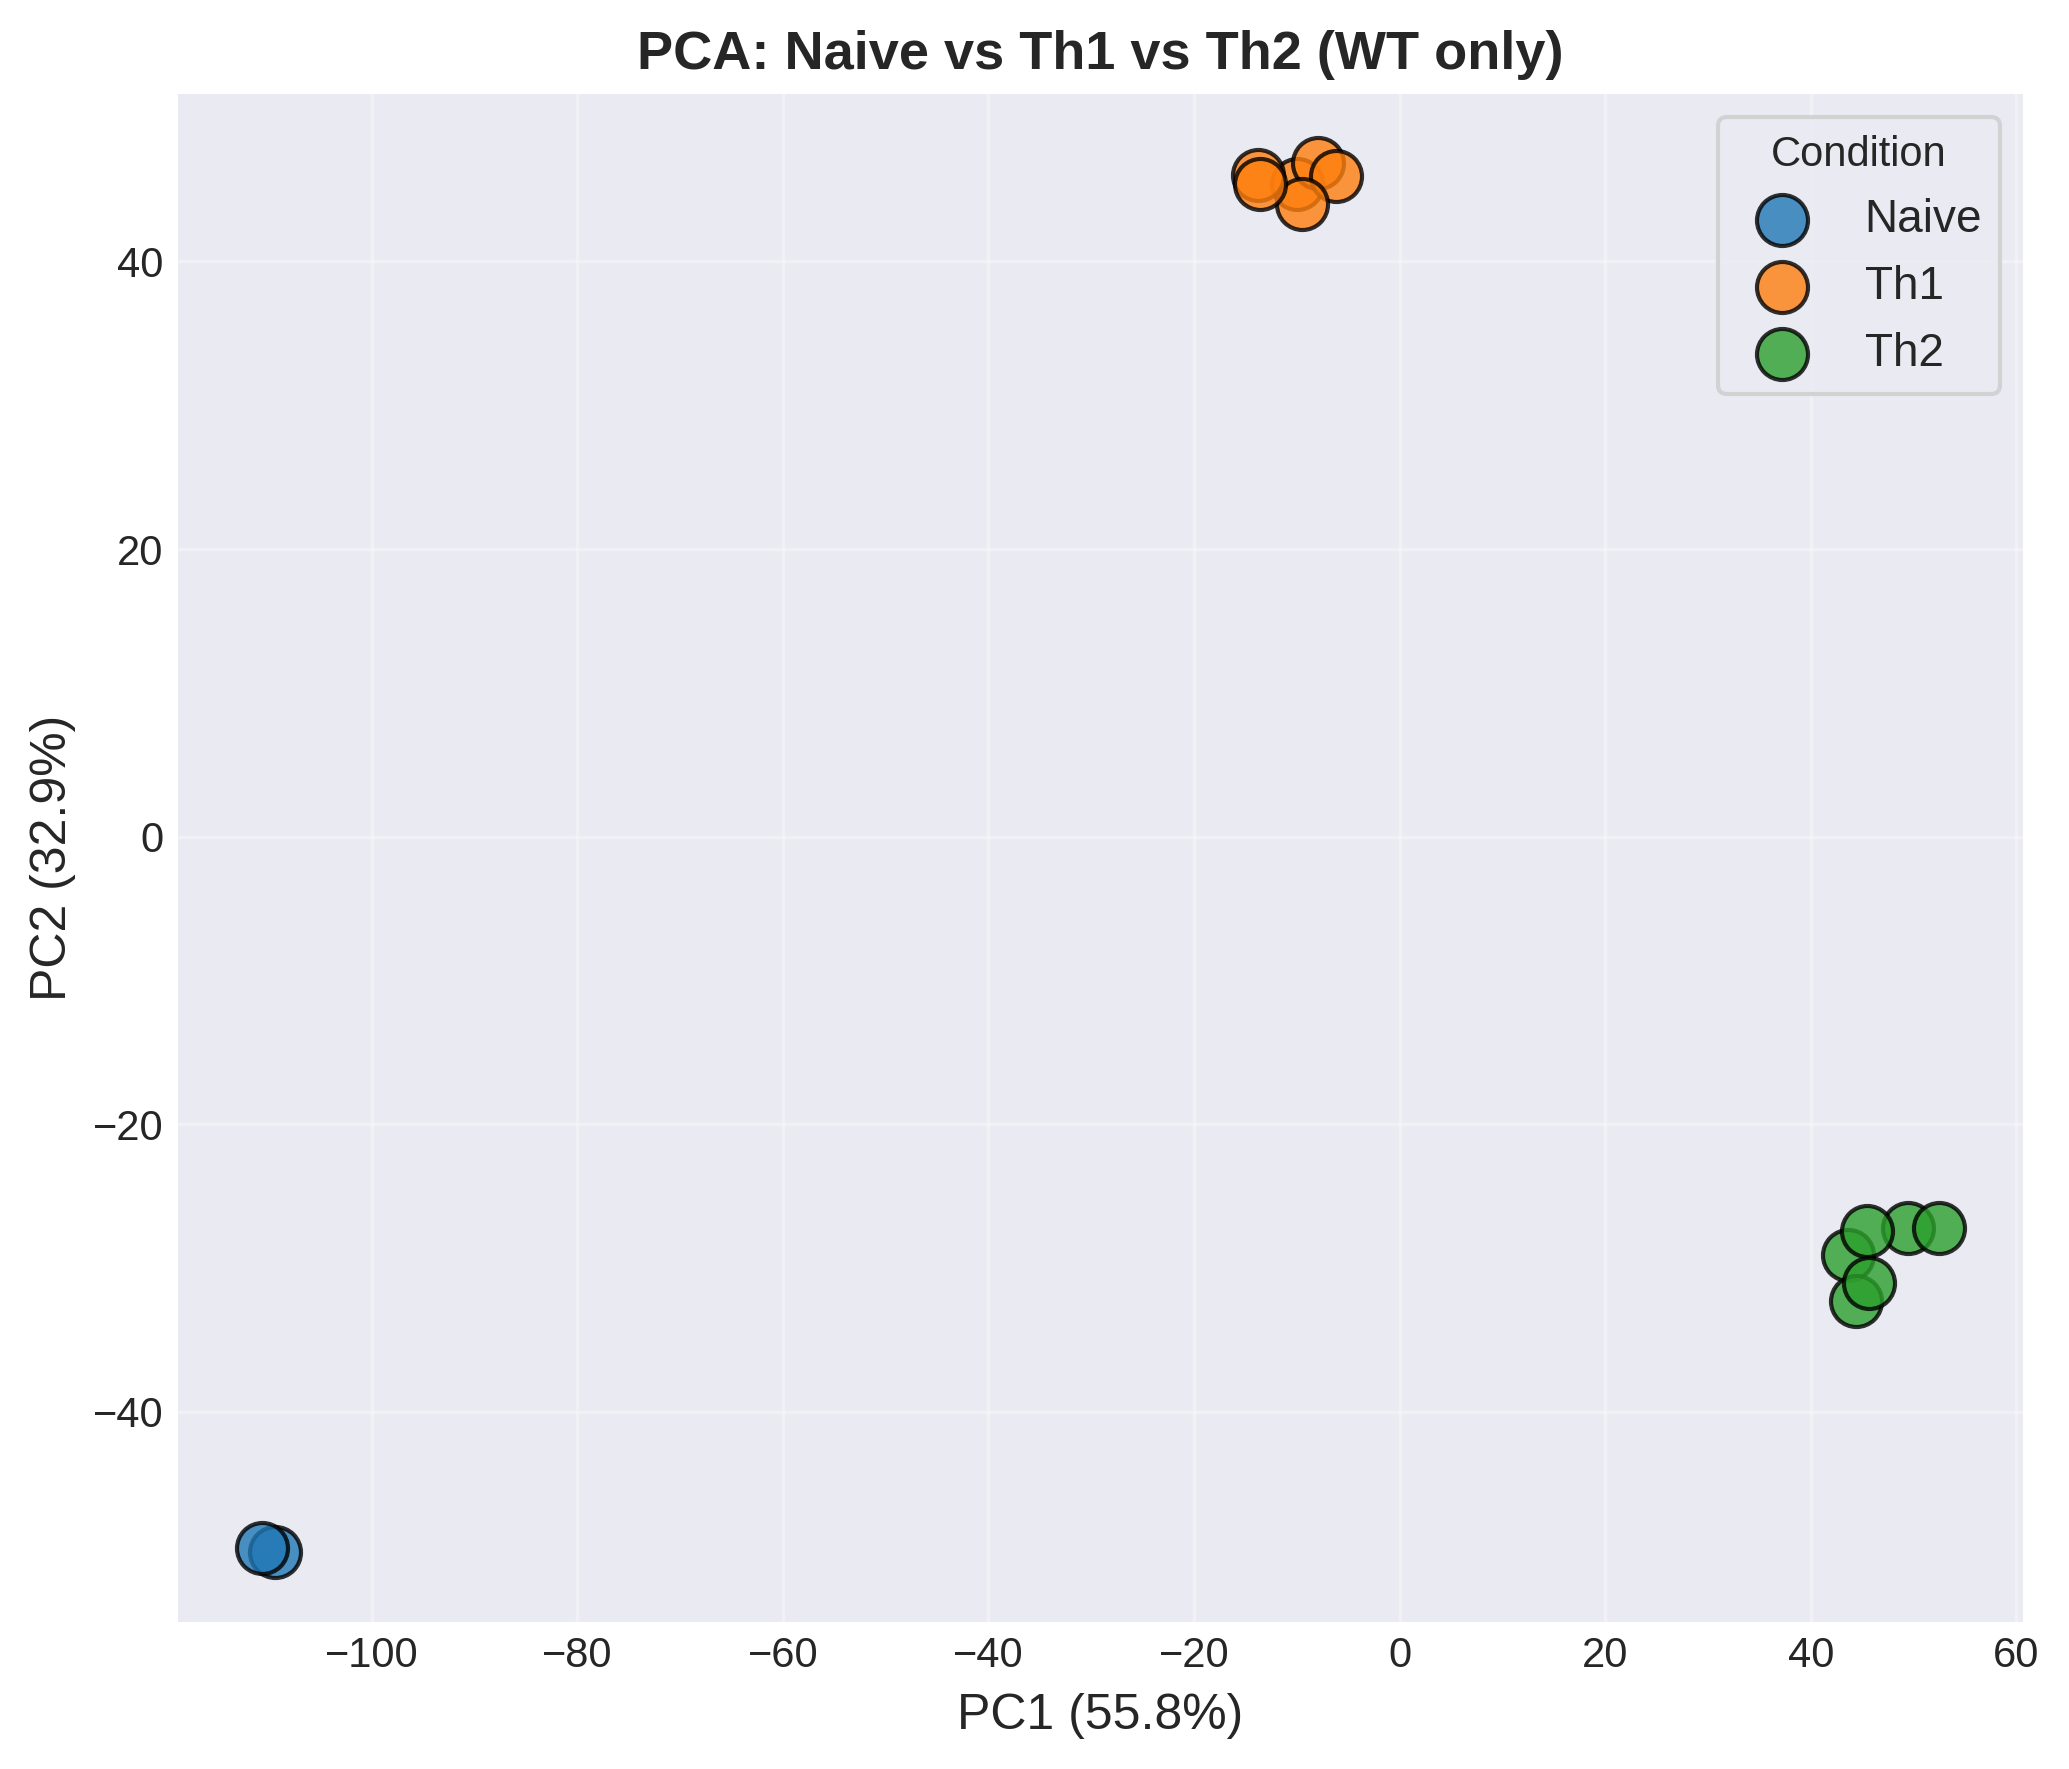


=== gse123966_results/01_PCA_samples.png ===


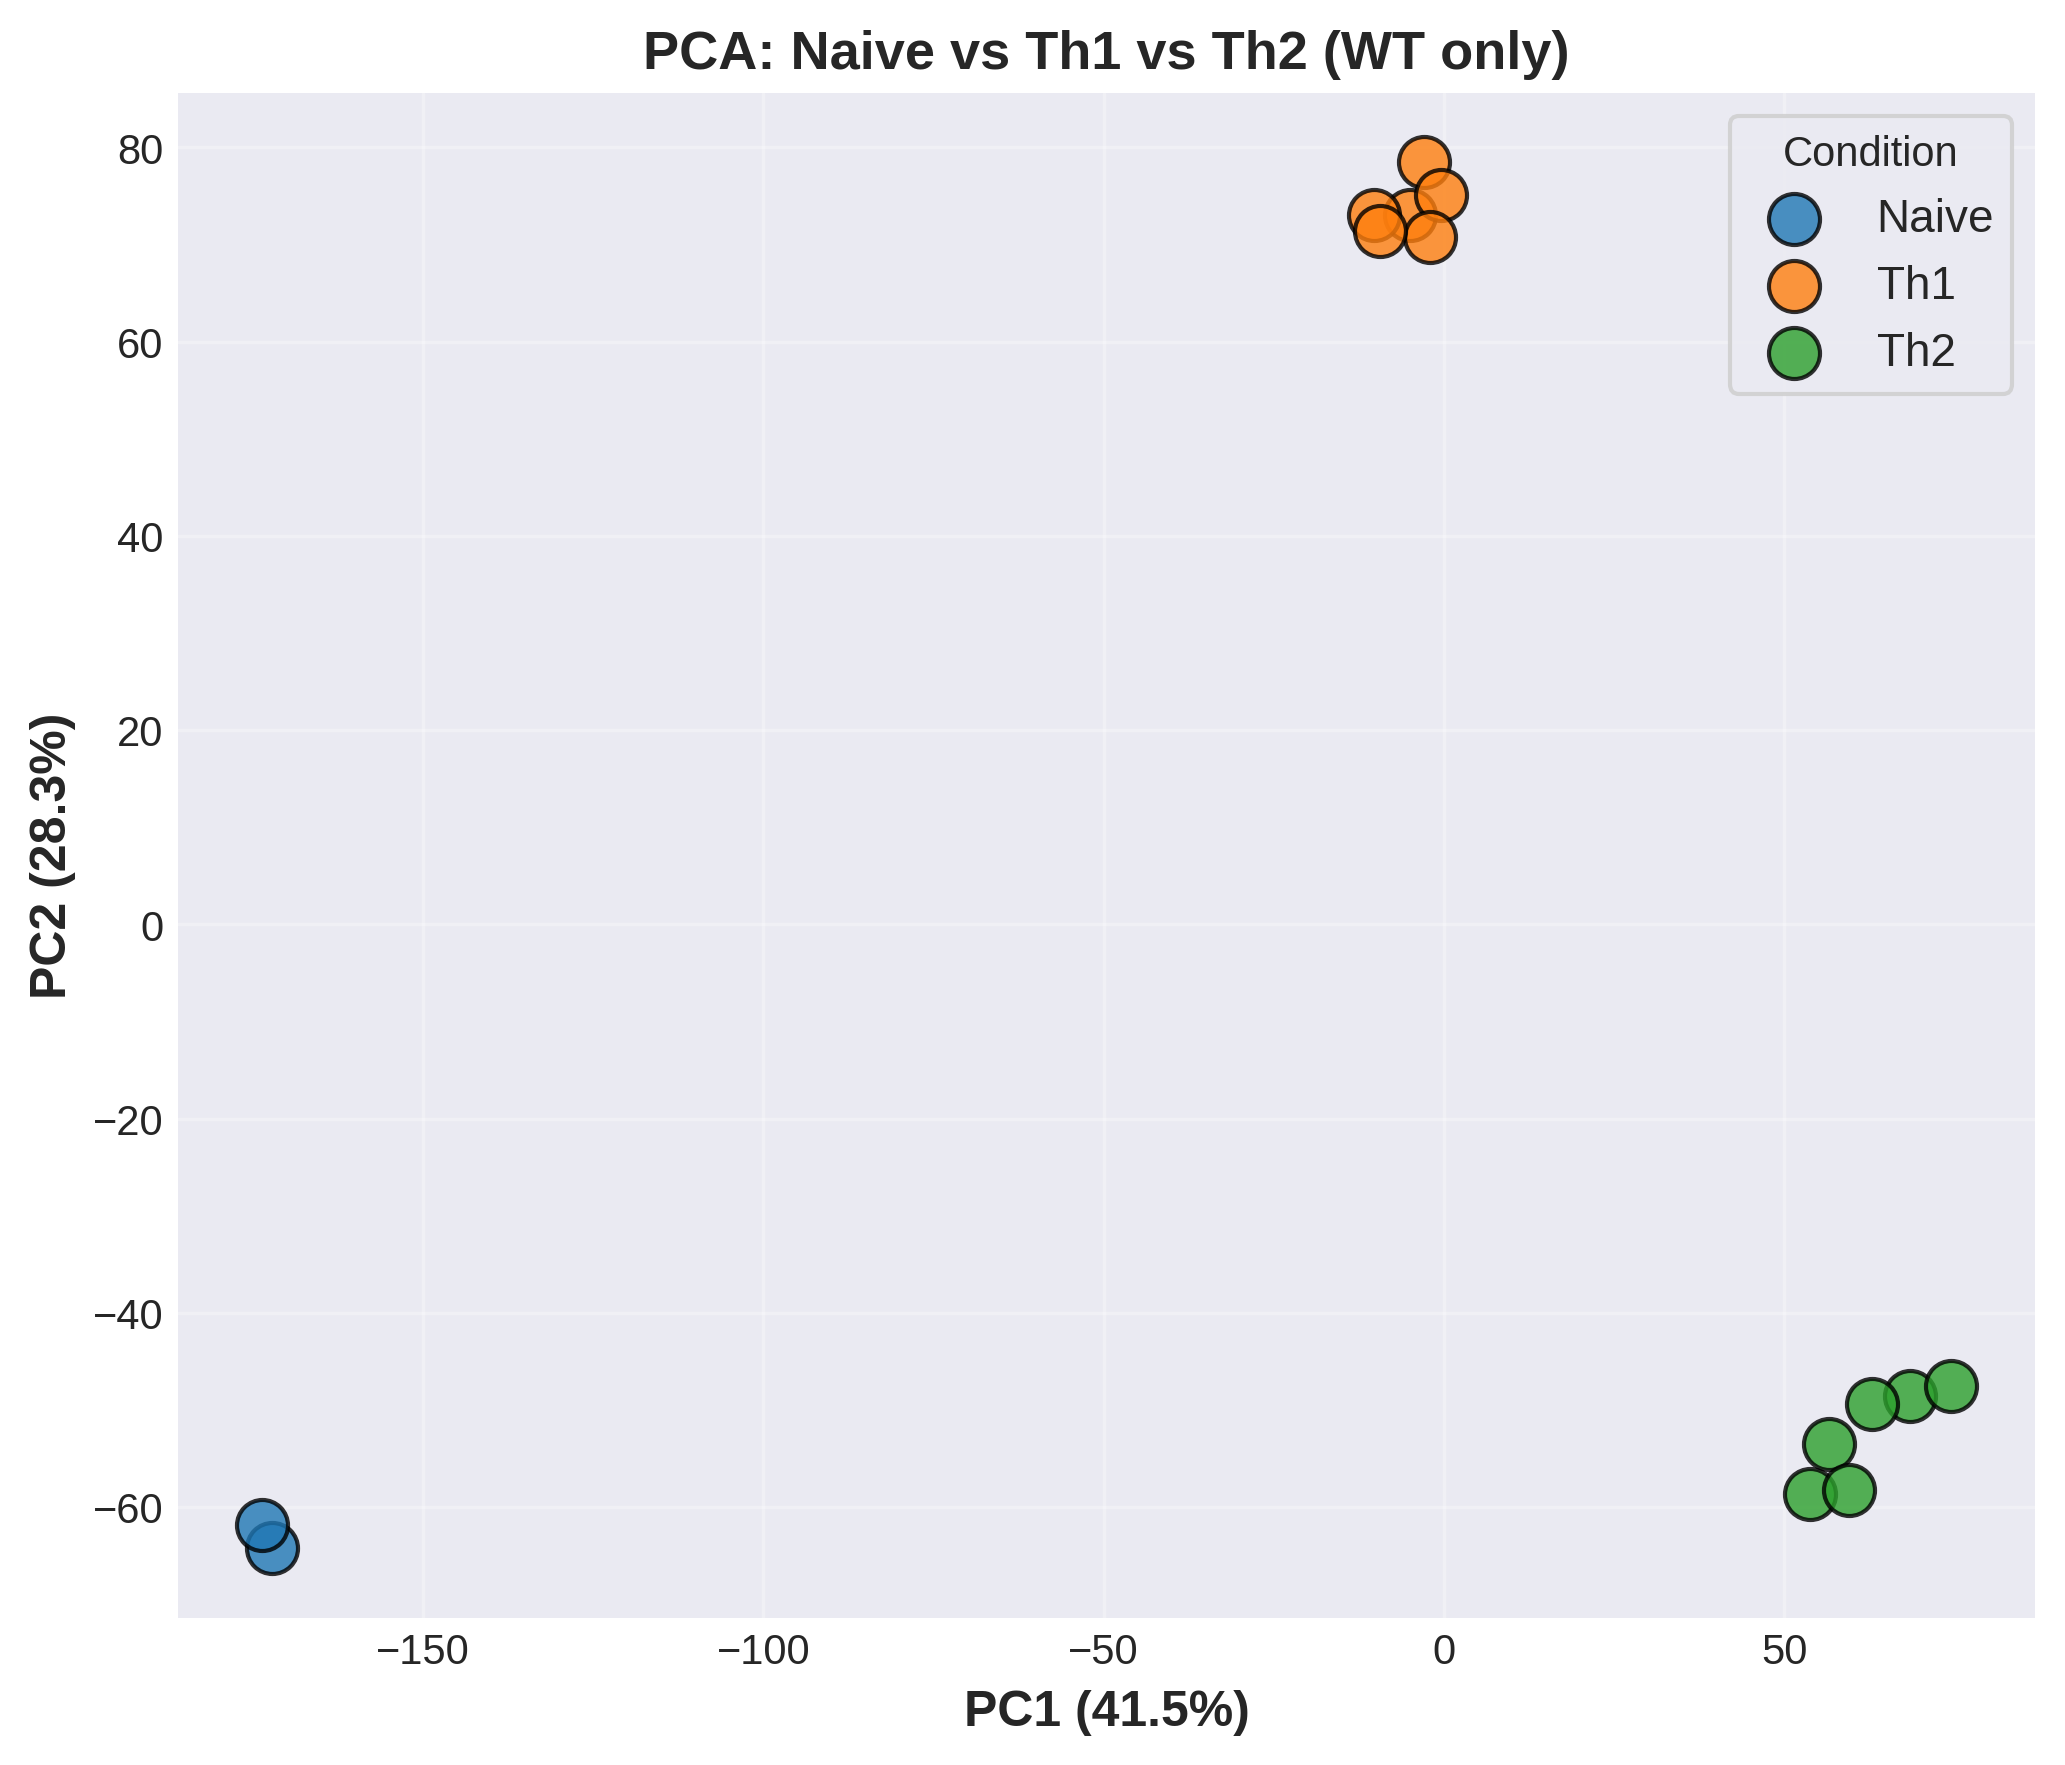


=== gse123966_results/enrichment_Th1_vs_Naive_GO_Biological_Process_2023.png ===


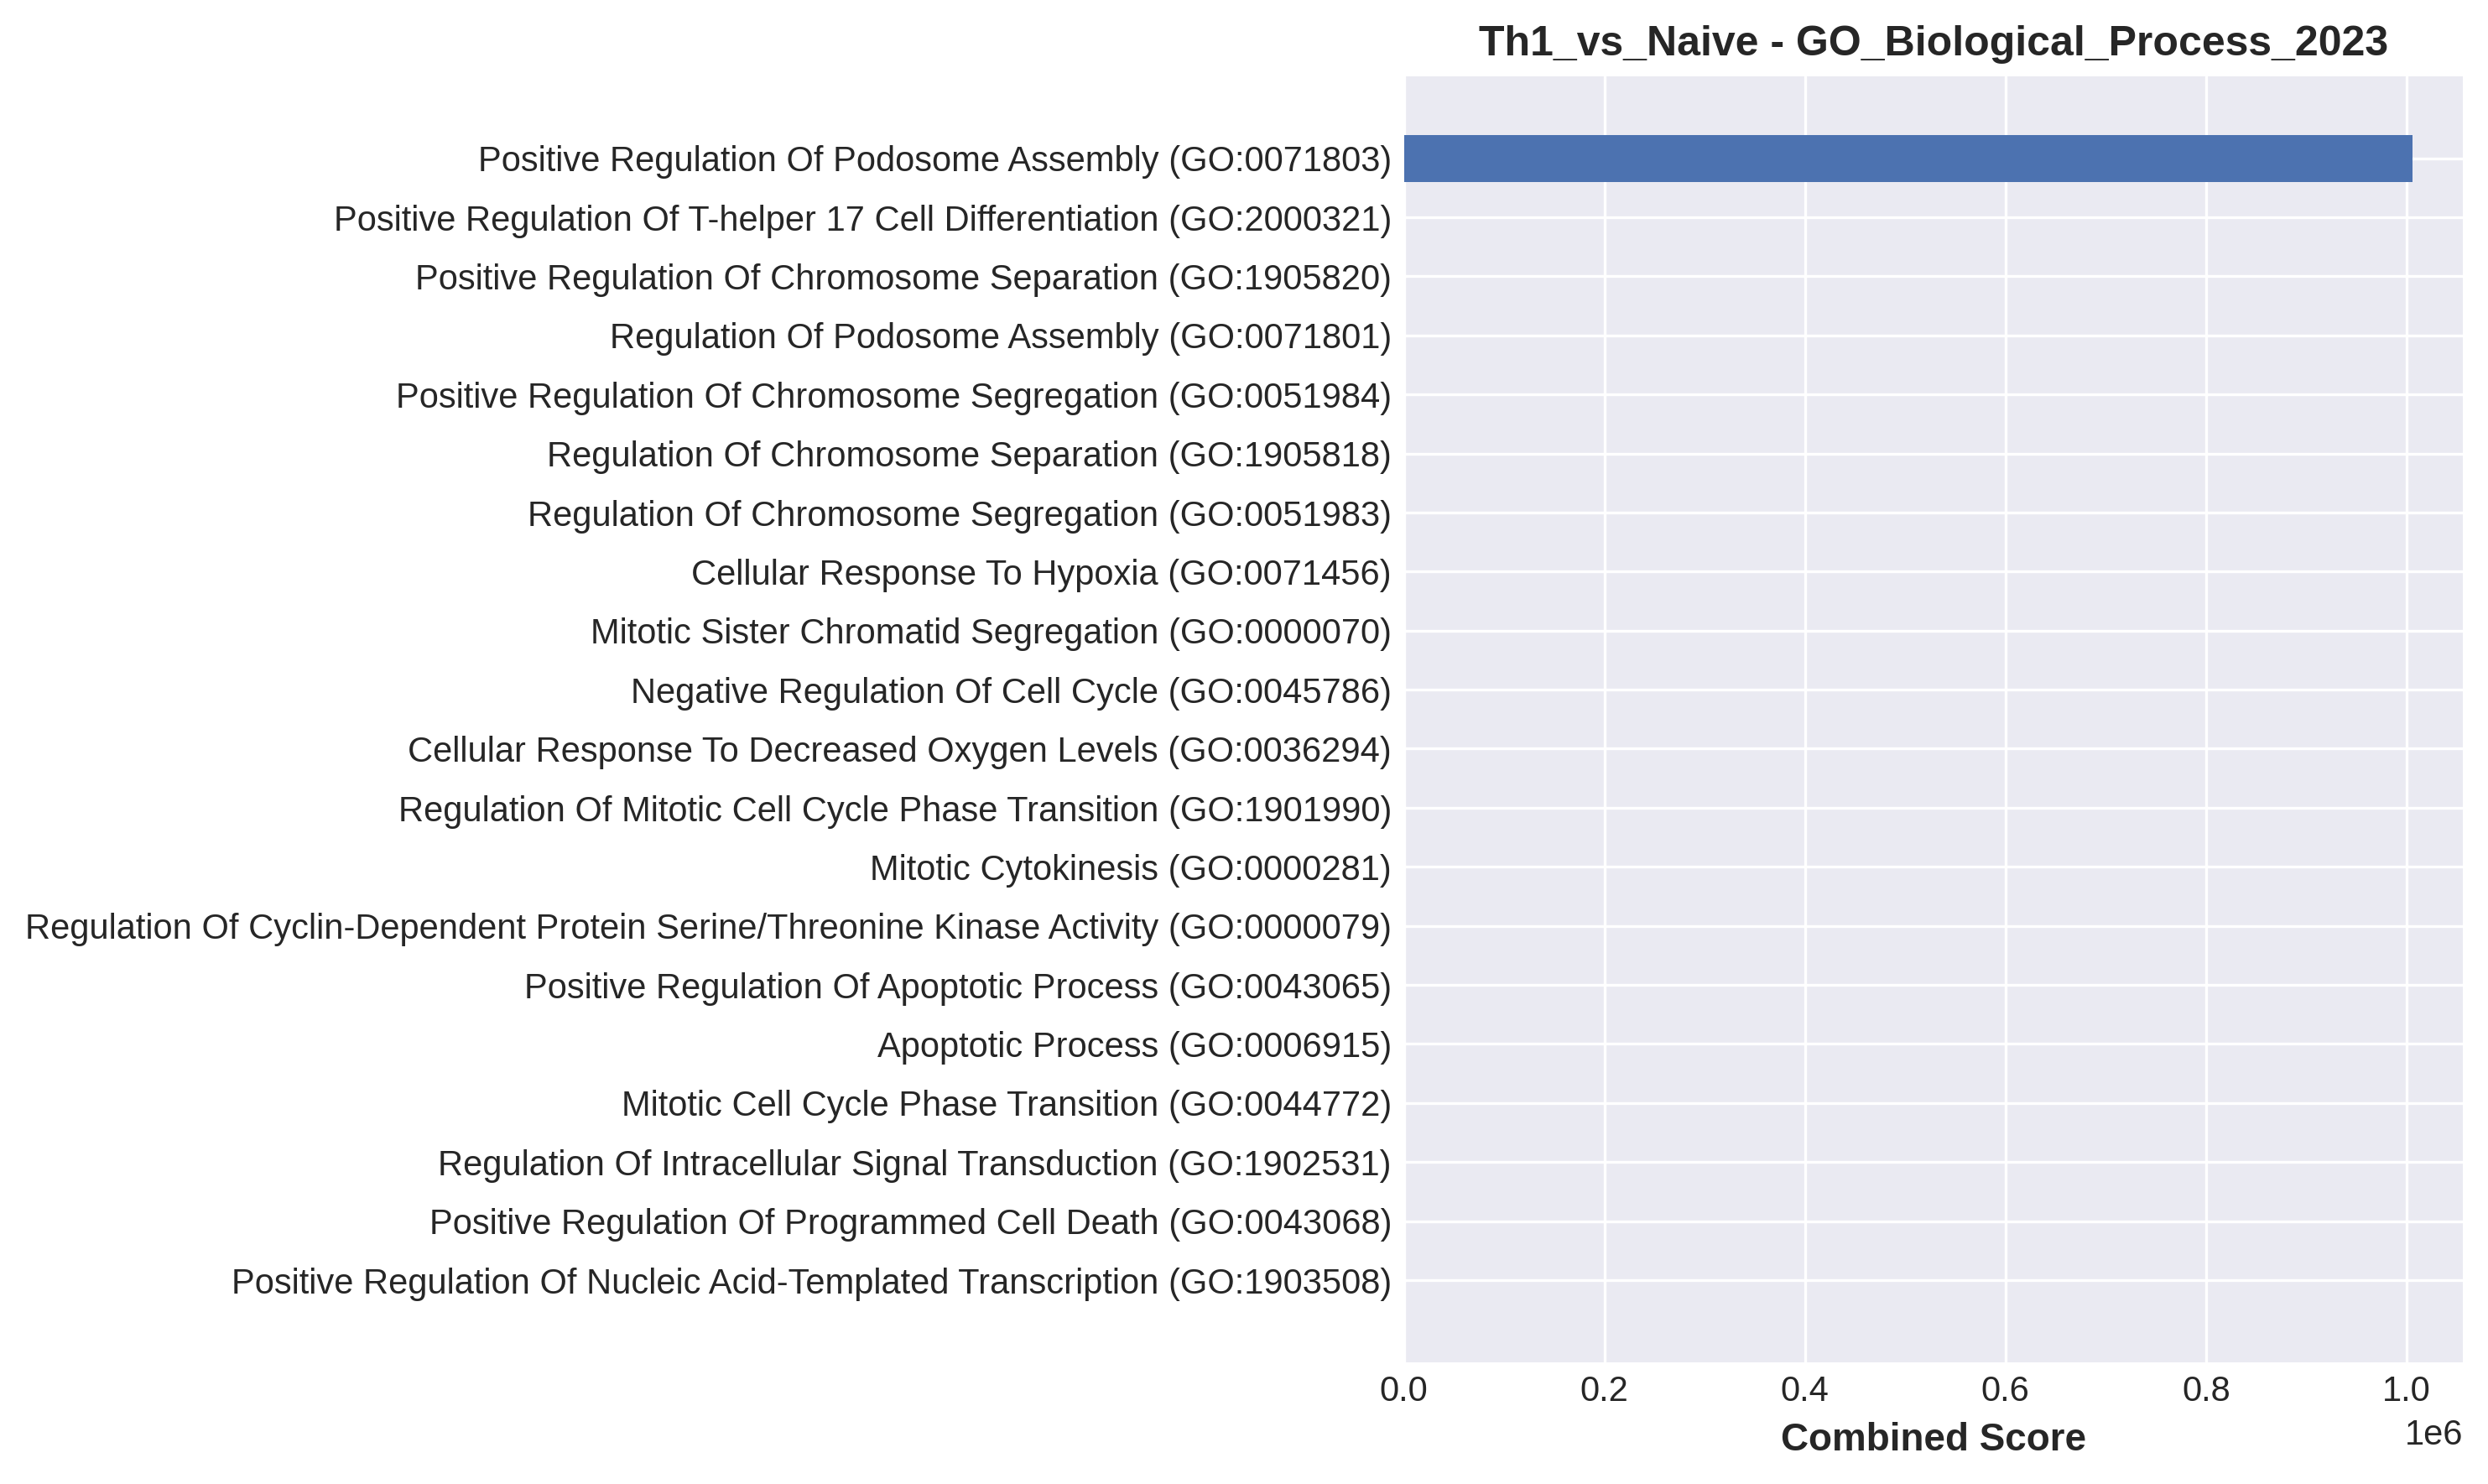


=== gse123966_results/enrichment_Th1_vs_Naive_KEGG_2016.png ===


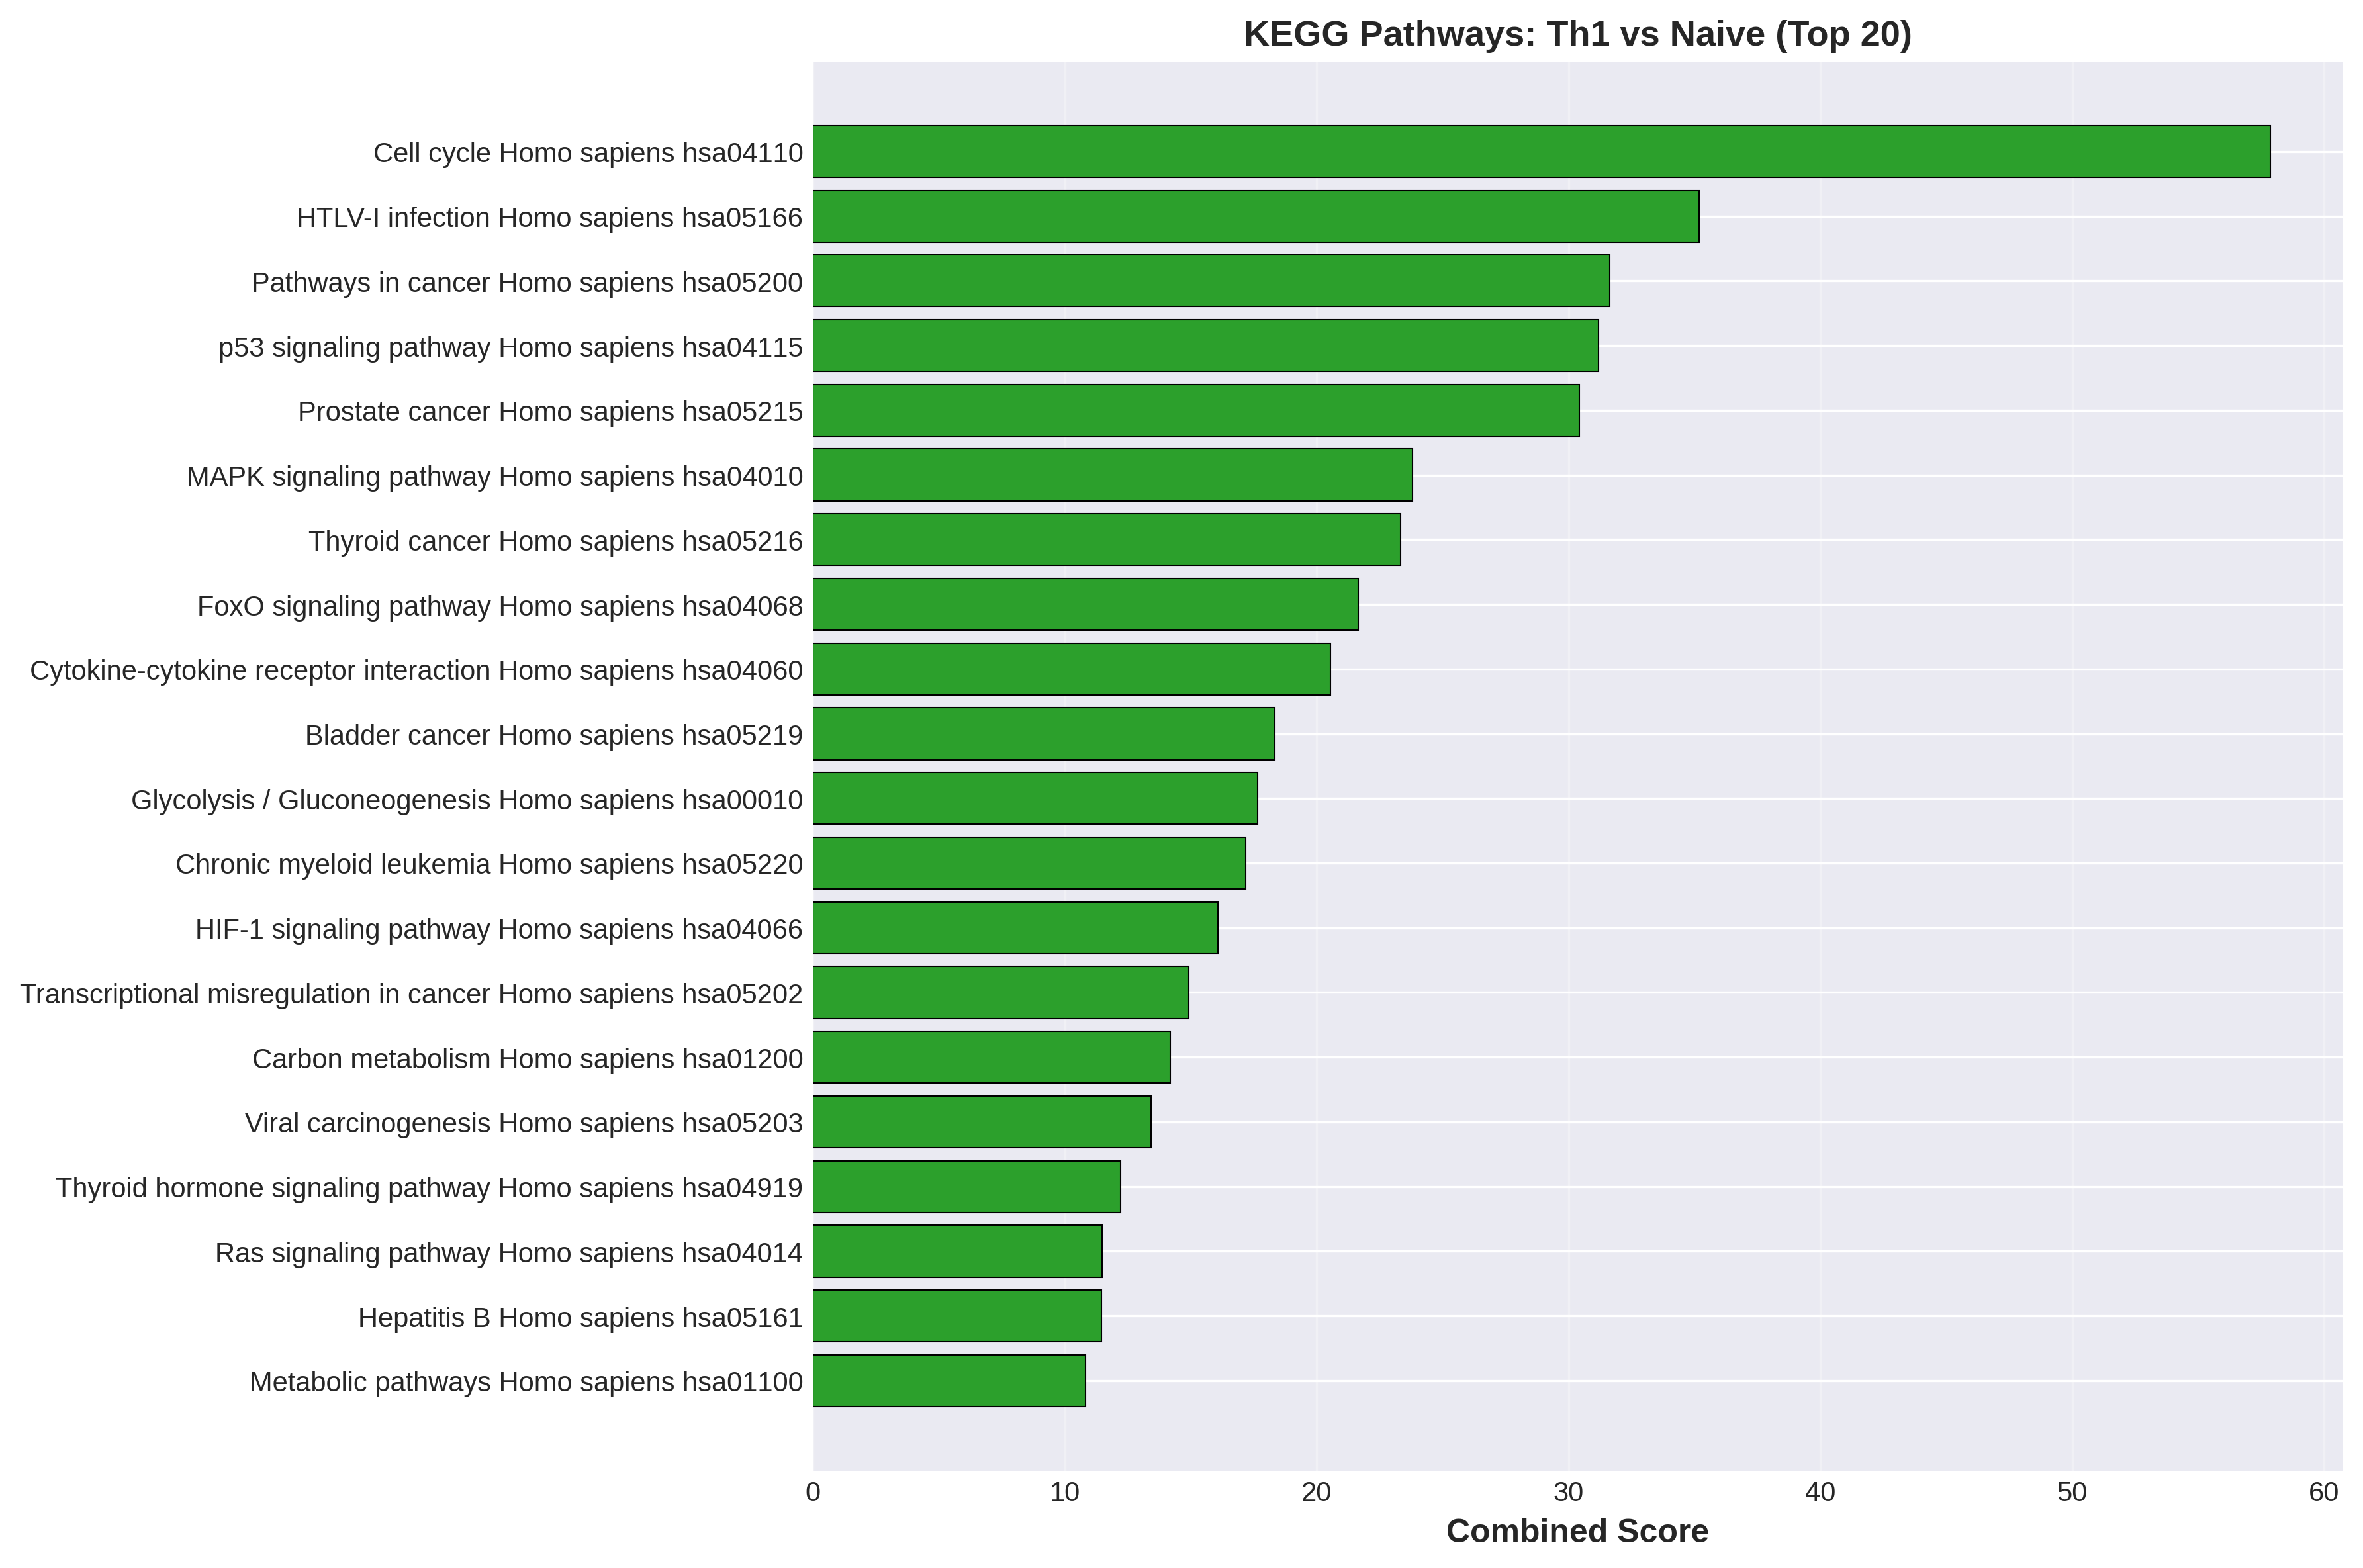


=== gse123966_results/enrichment_Th2_vs_Naive_GO_Biological_Process_2023.png ===


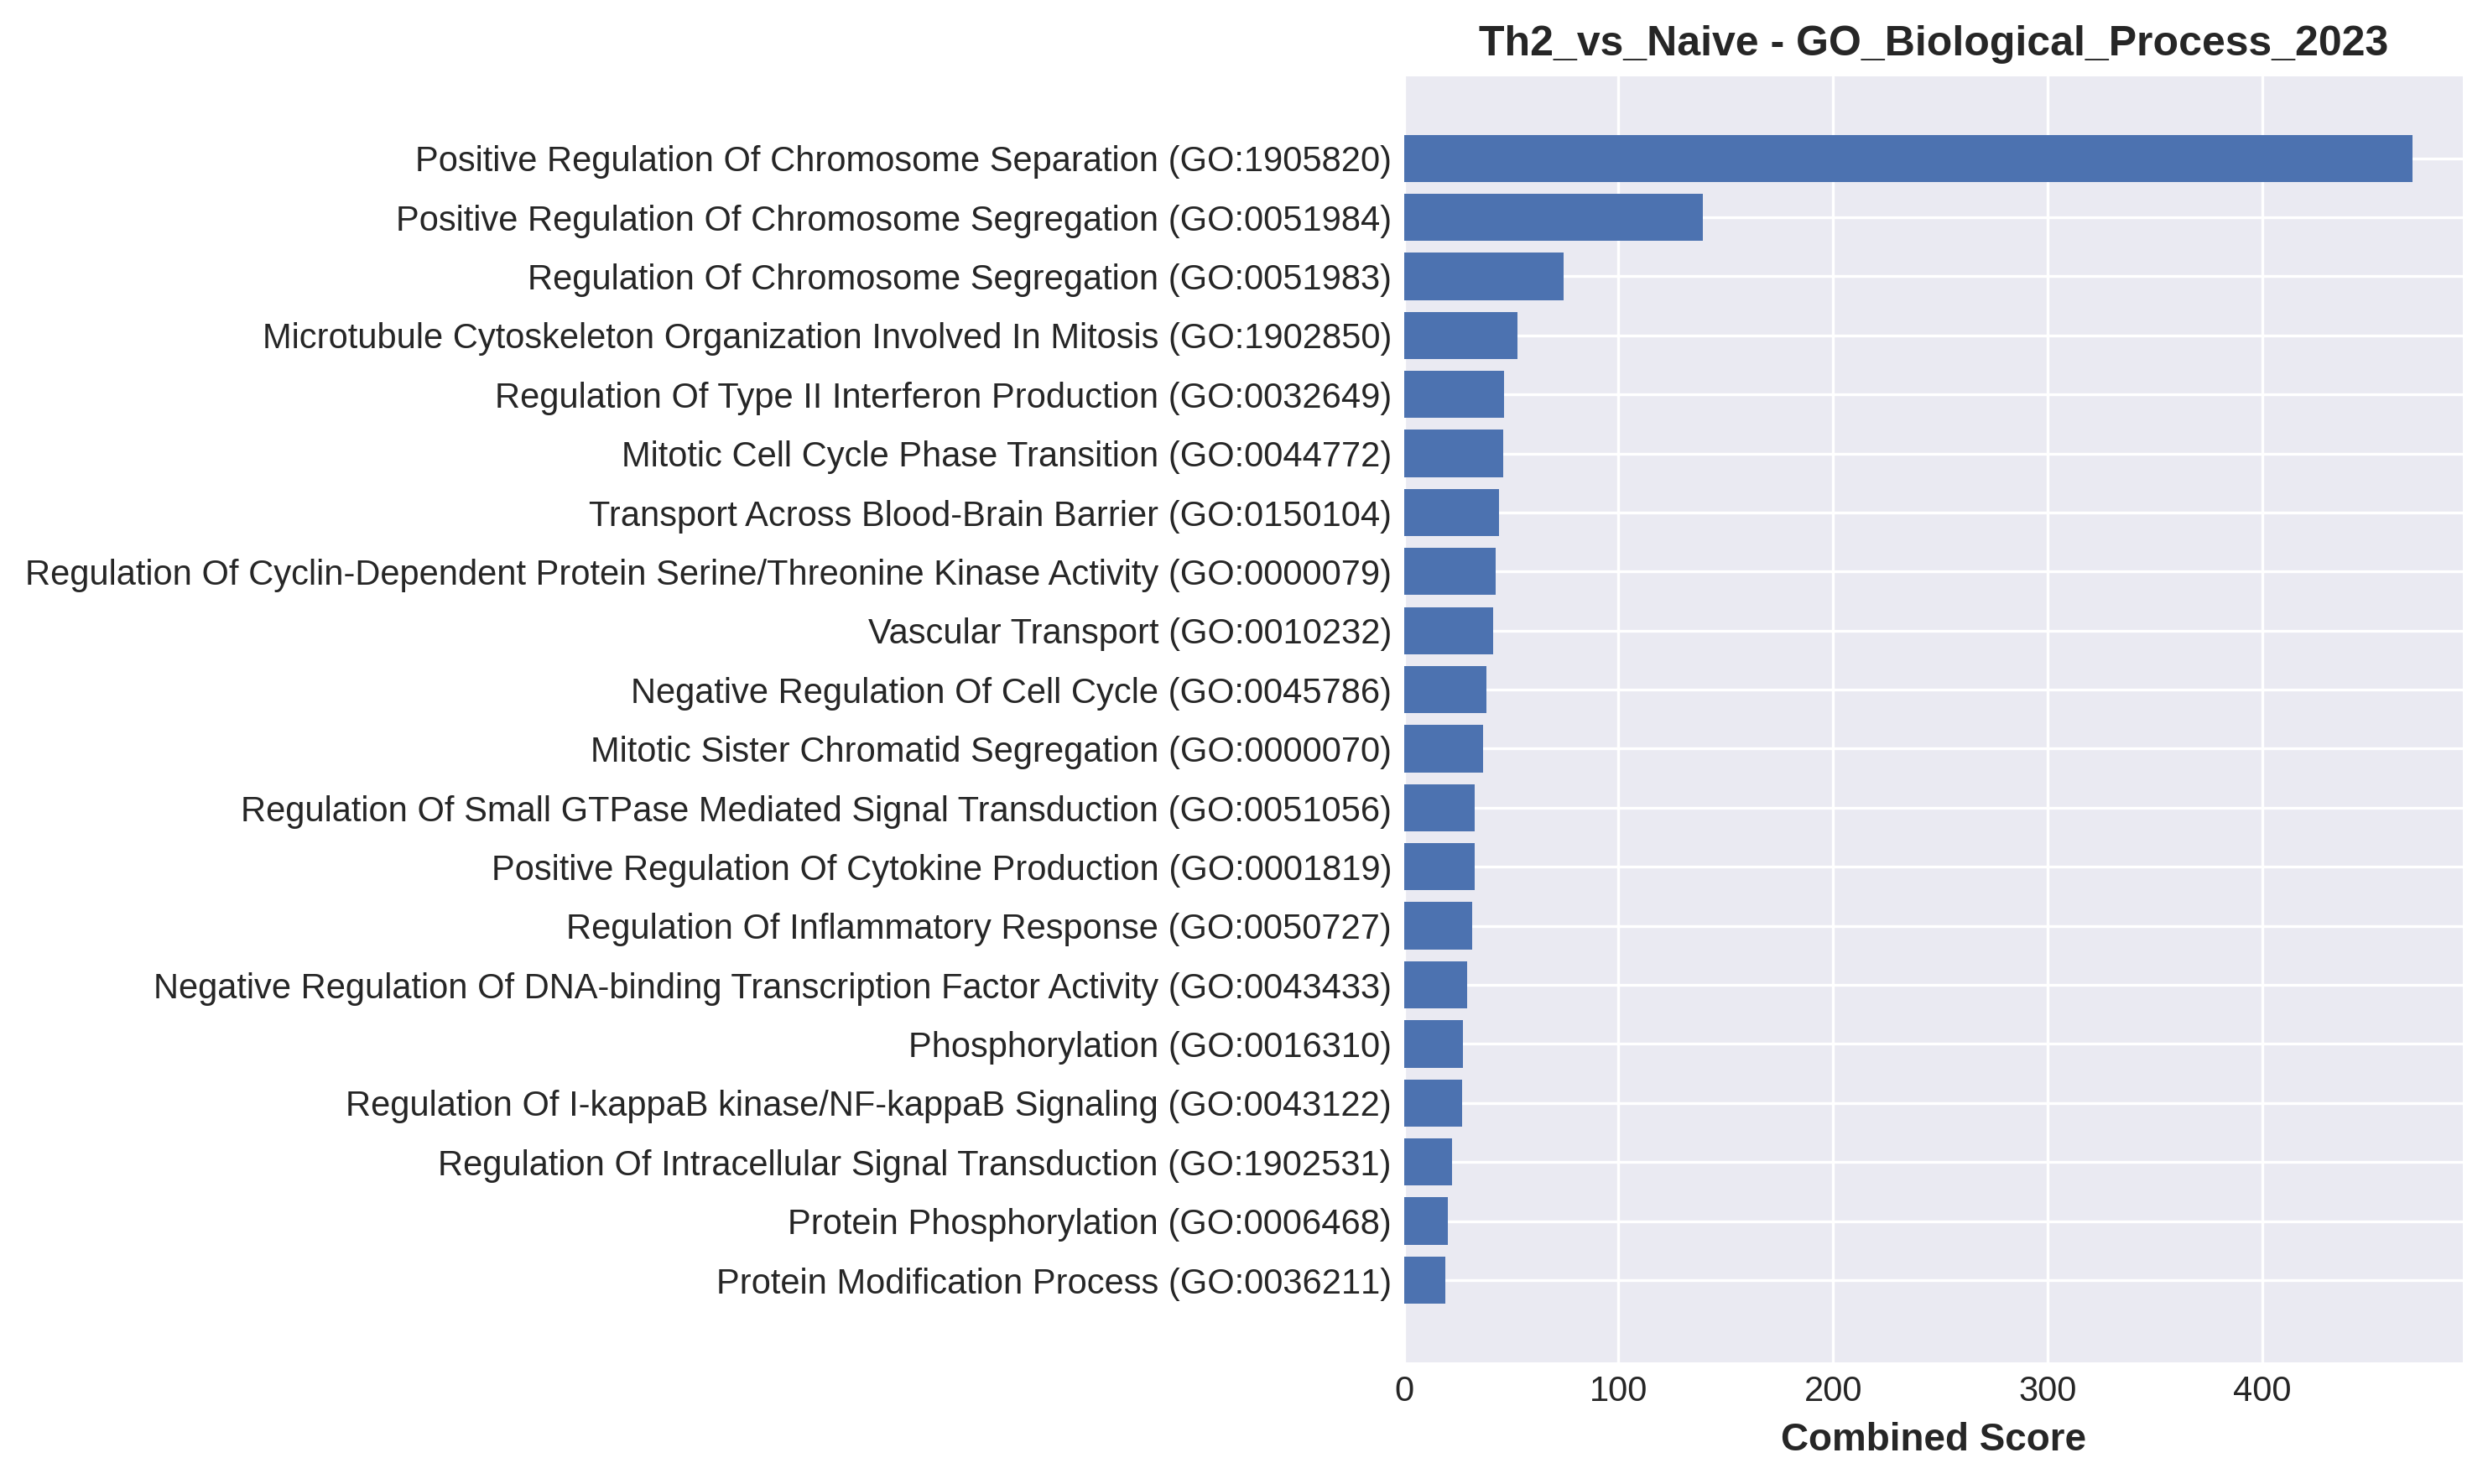


=== gse123966_results/enrichment_Th2_vs_Naive_KEGG_2016.png ===


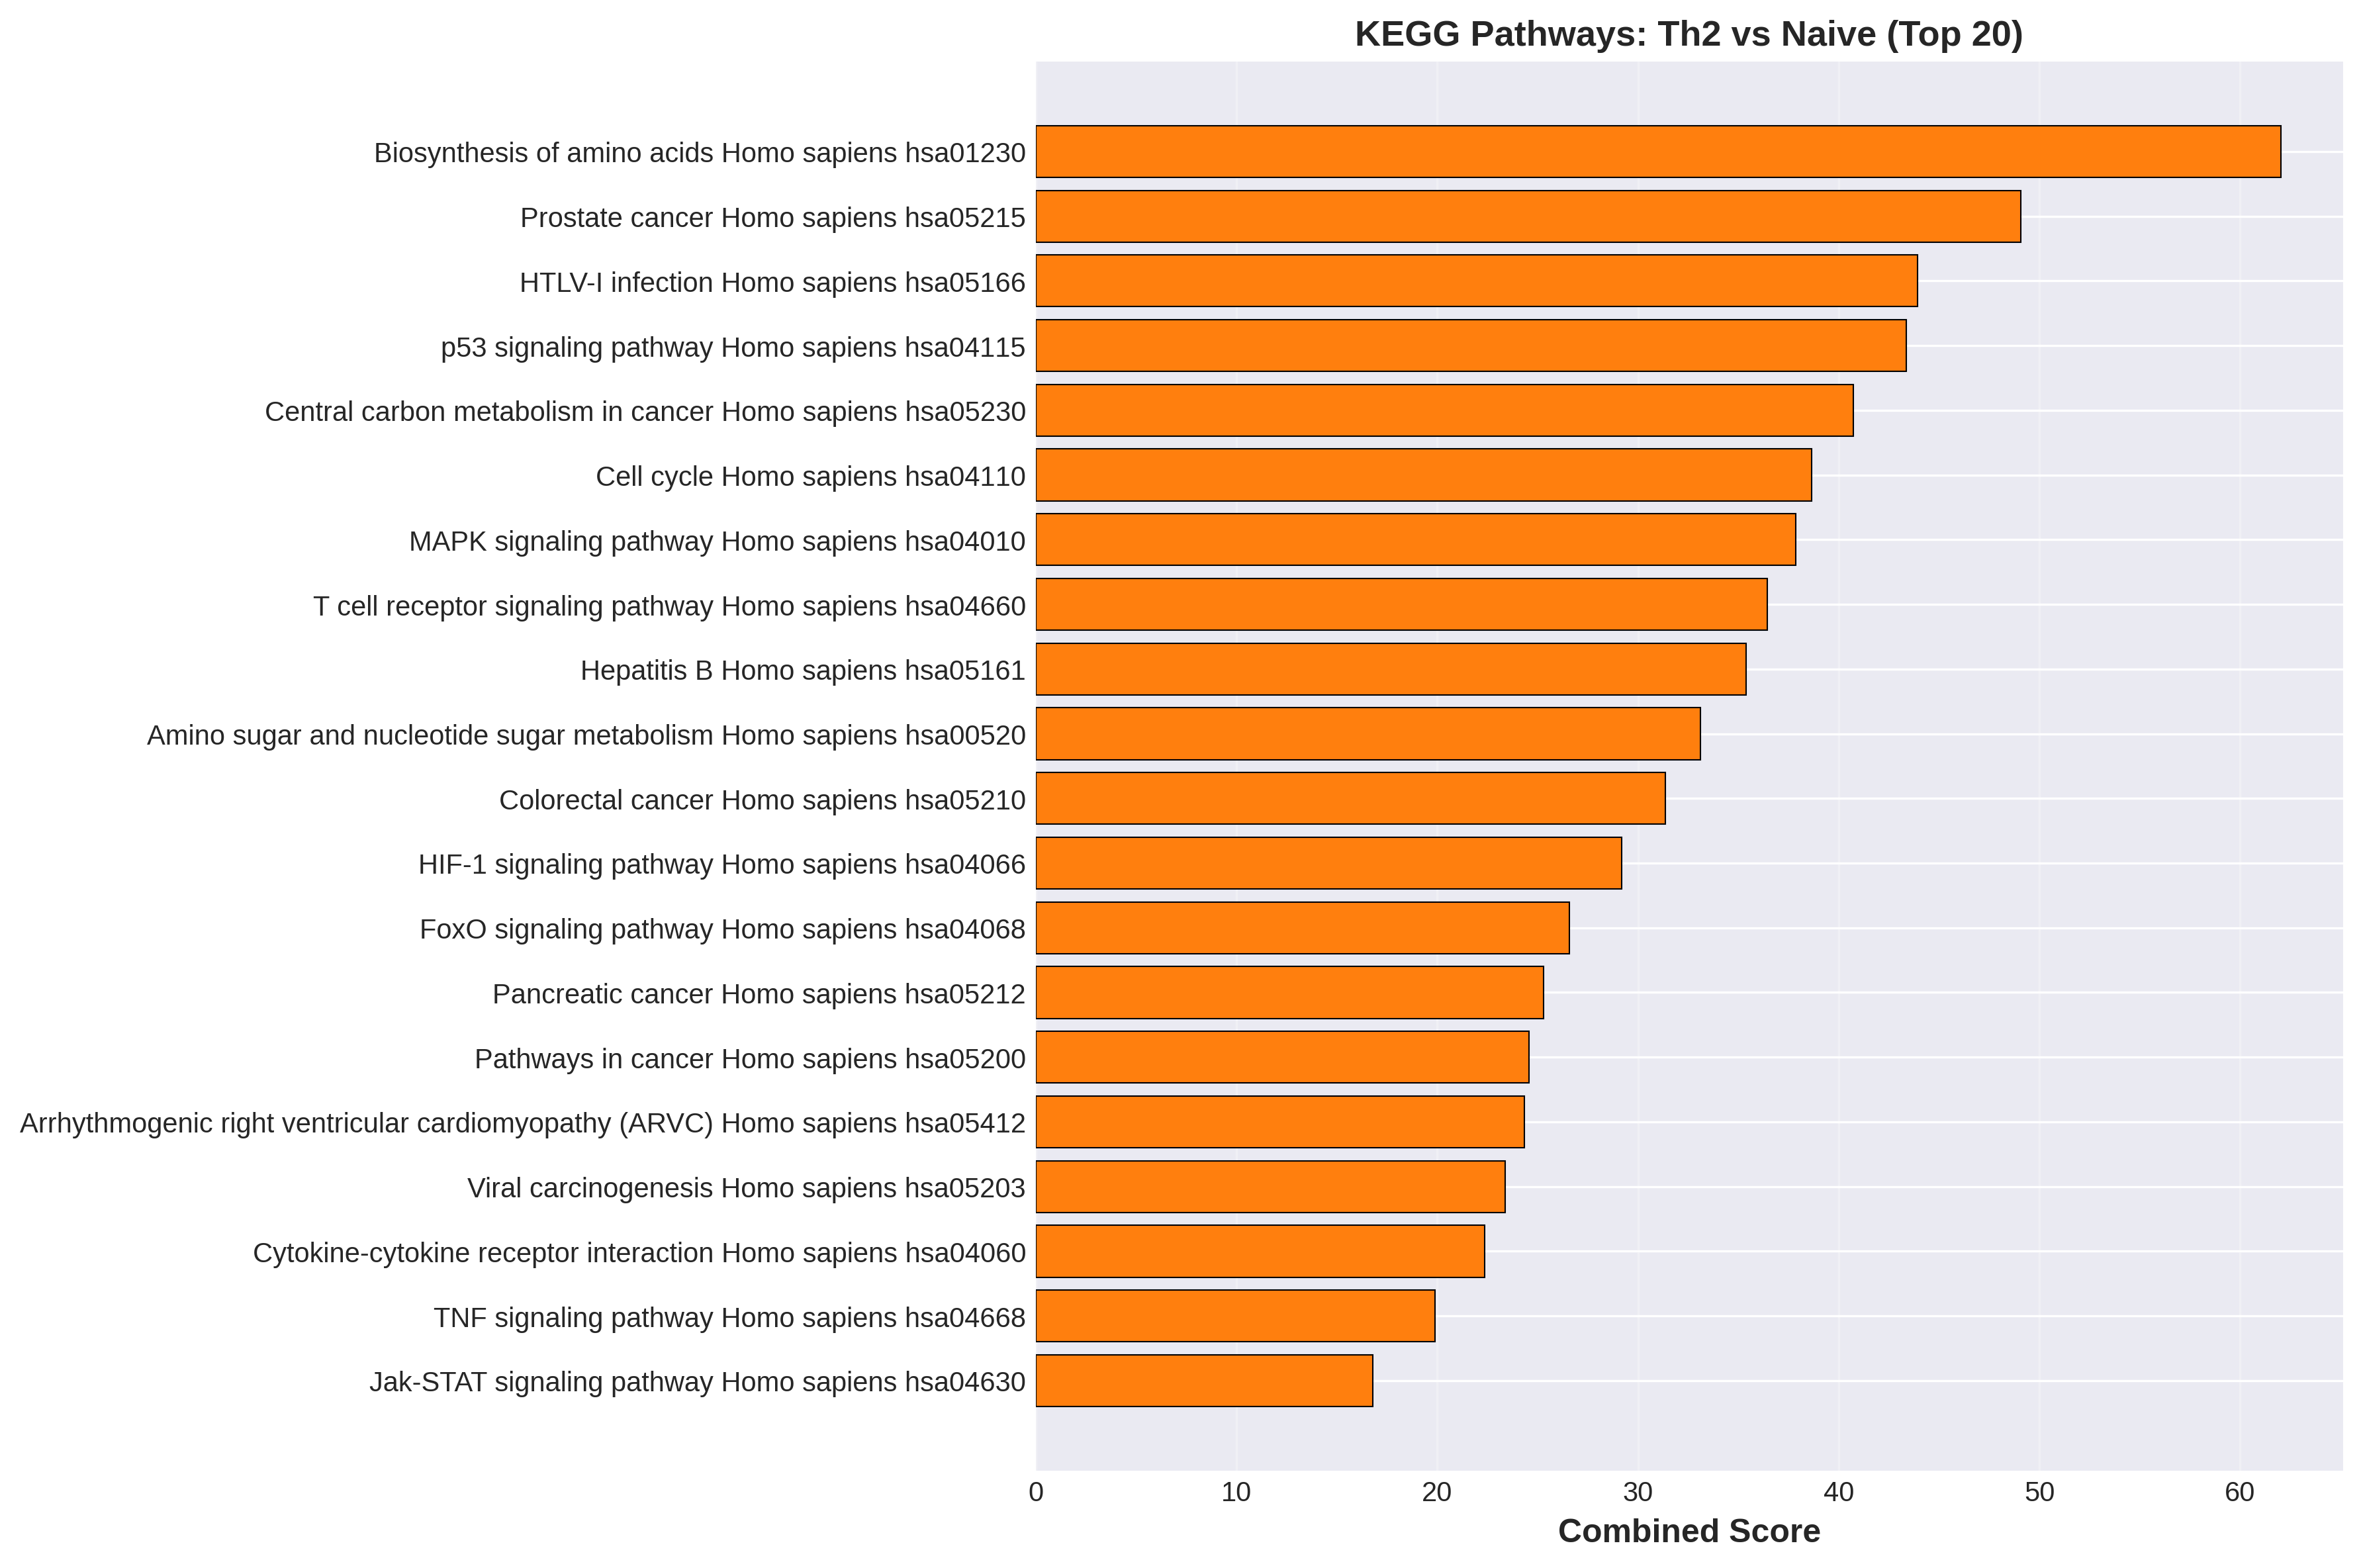


=== gse123966_results/heatmap_DEGs_Th1_vs_Naive.png ===


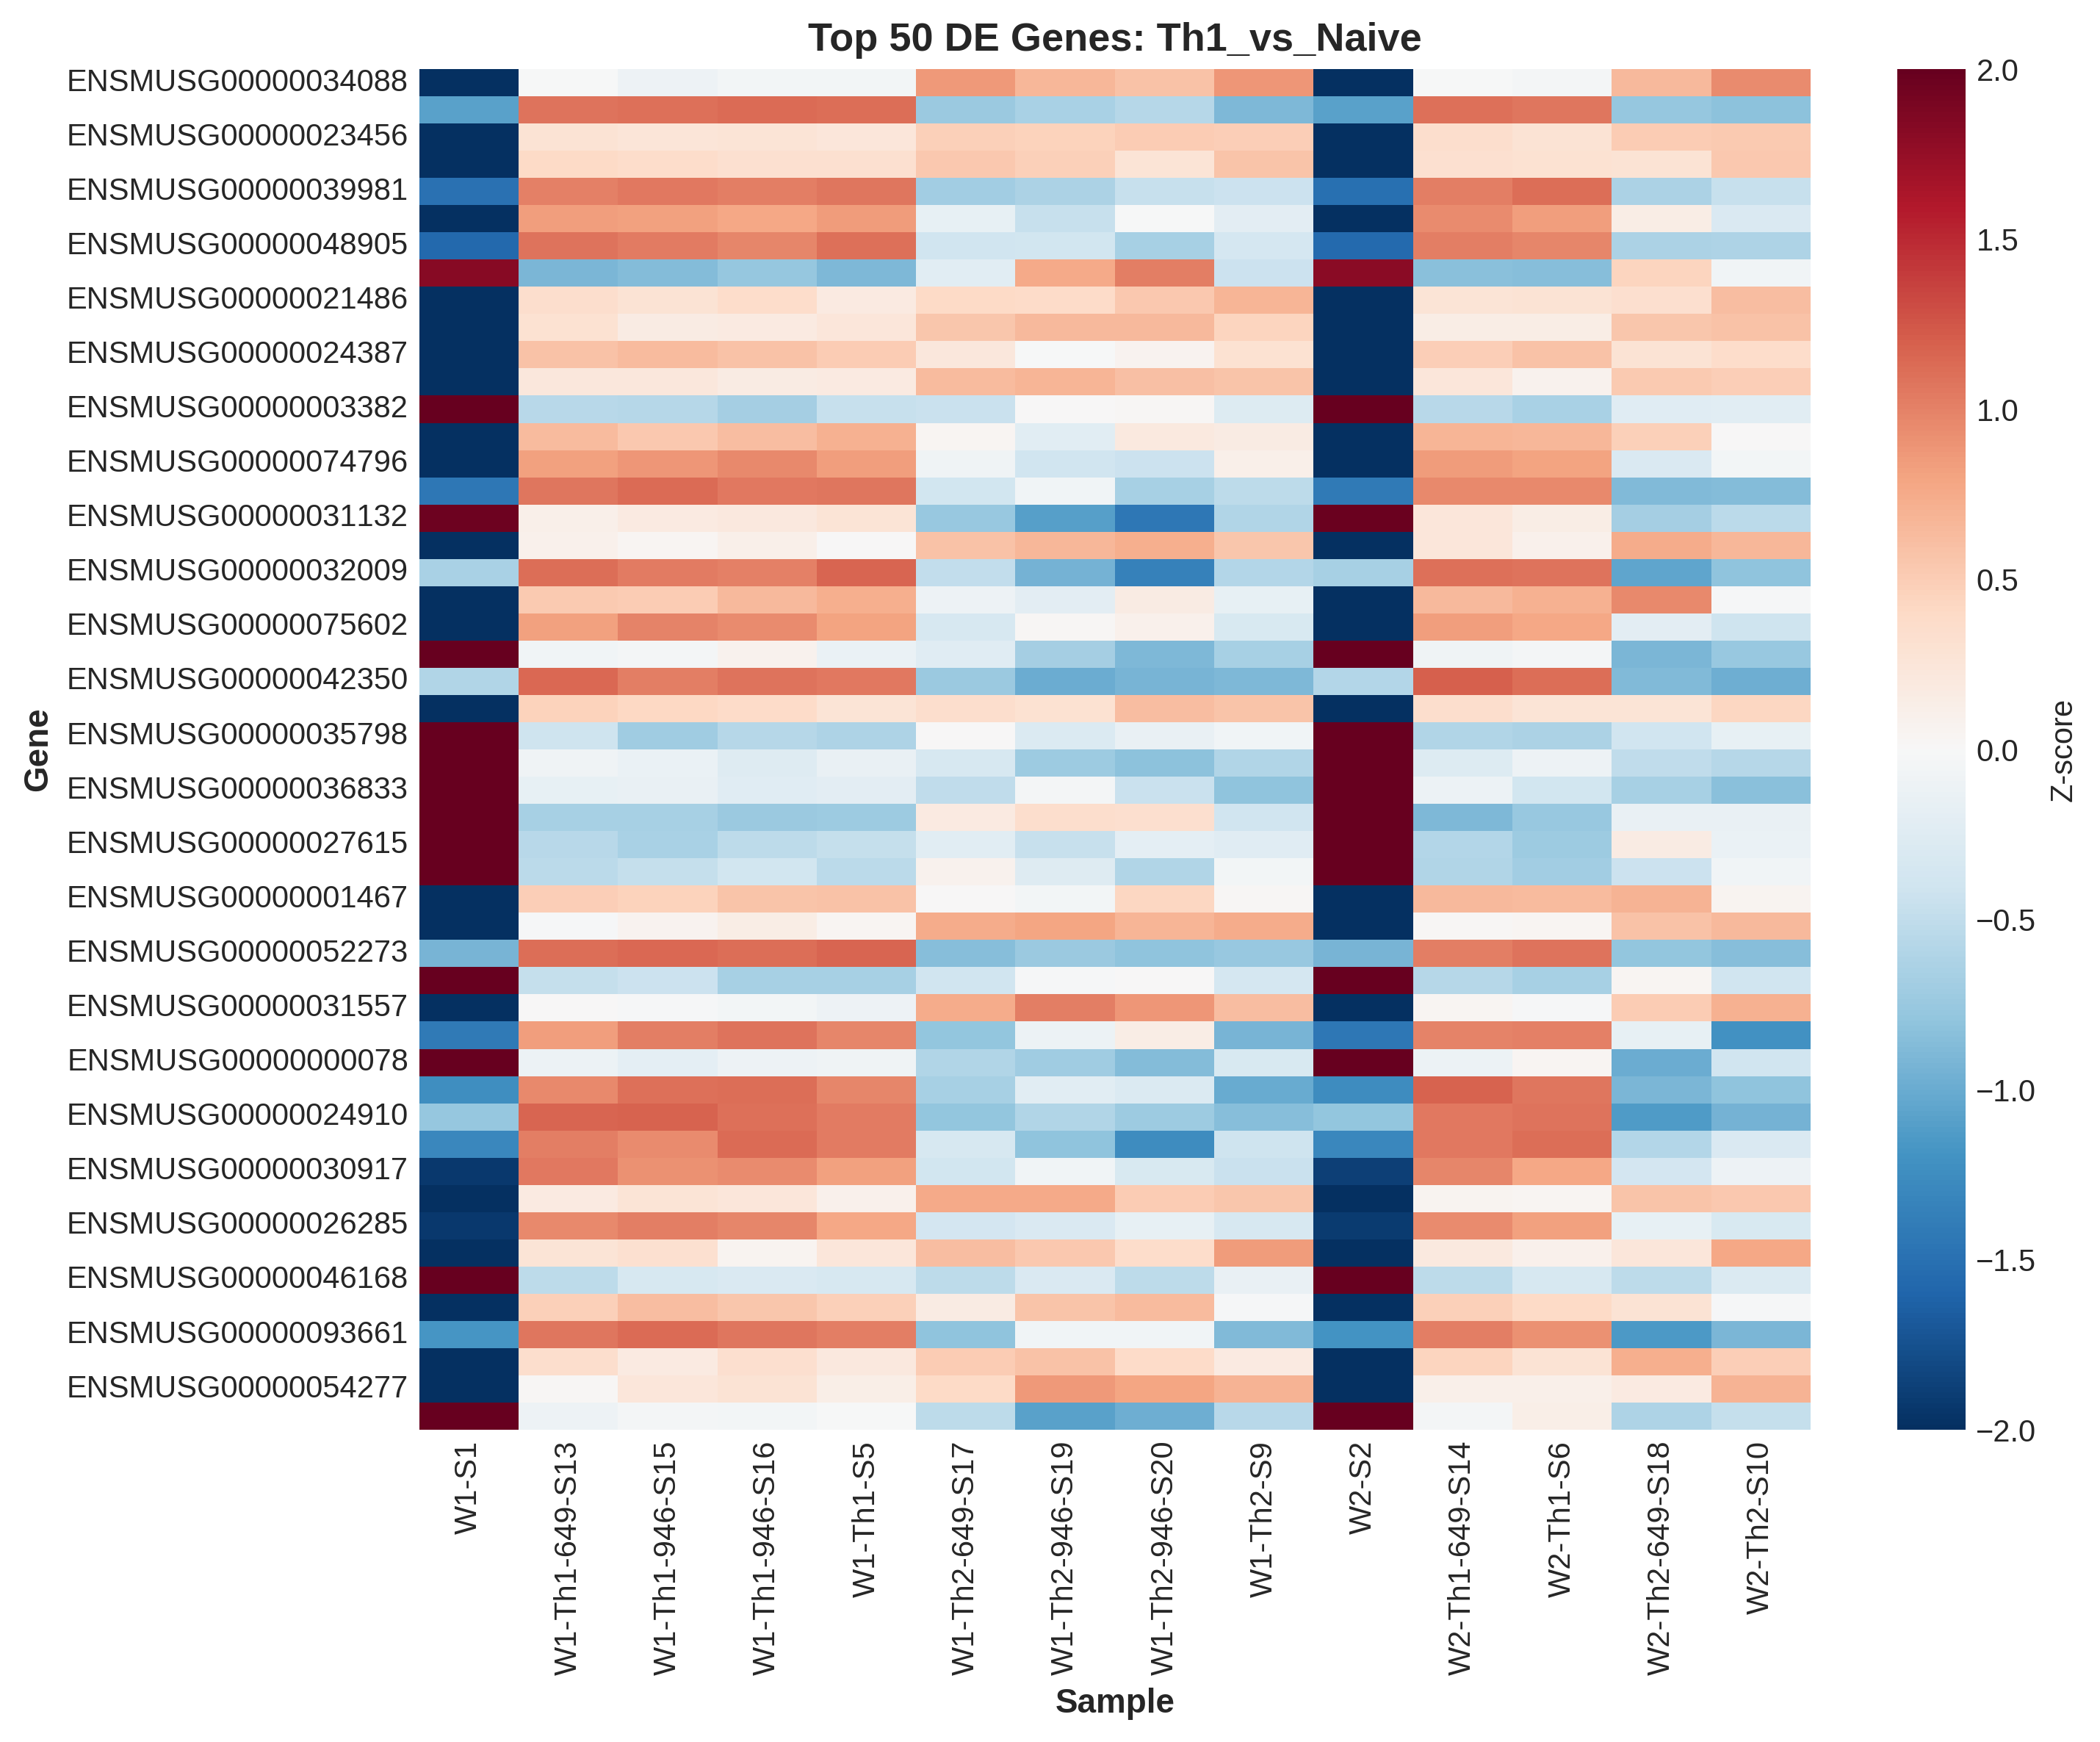


=== gse123966_results/heatmap_DEGs_Th2_vs_Naive.png ===


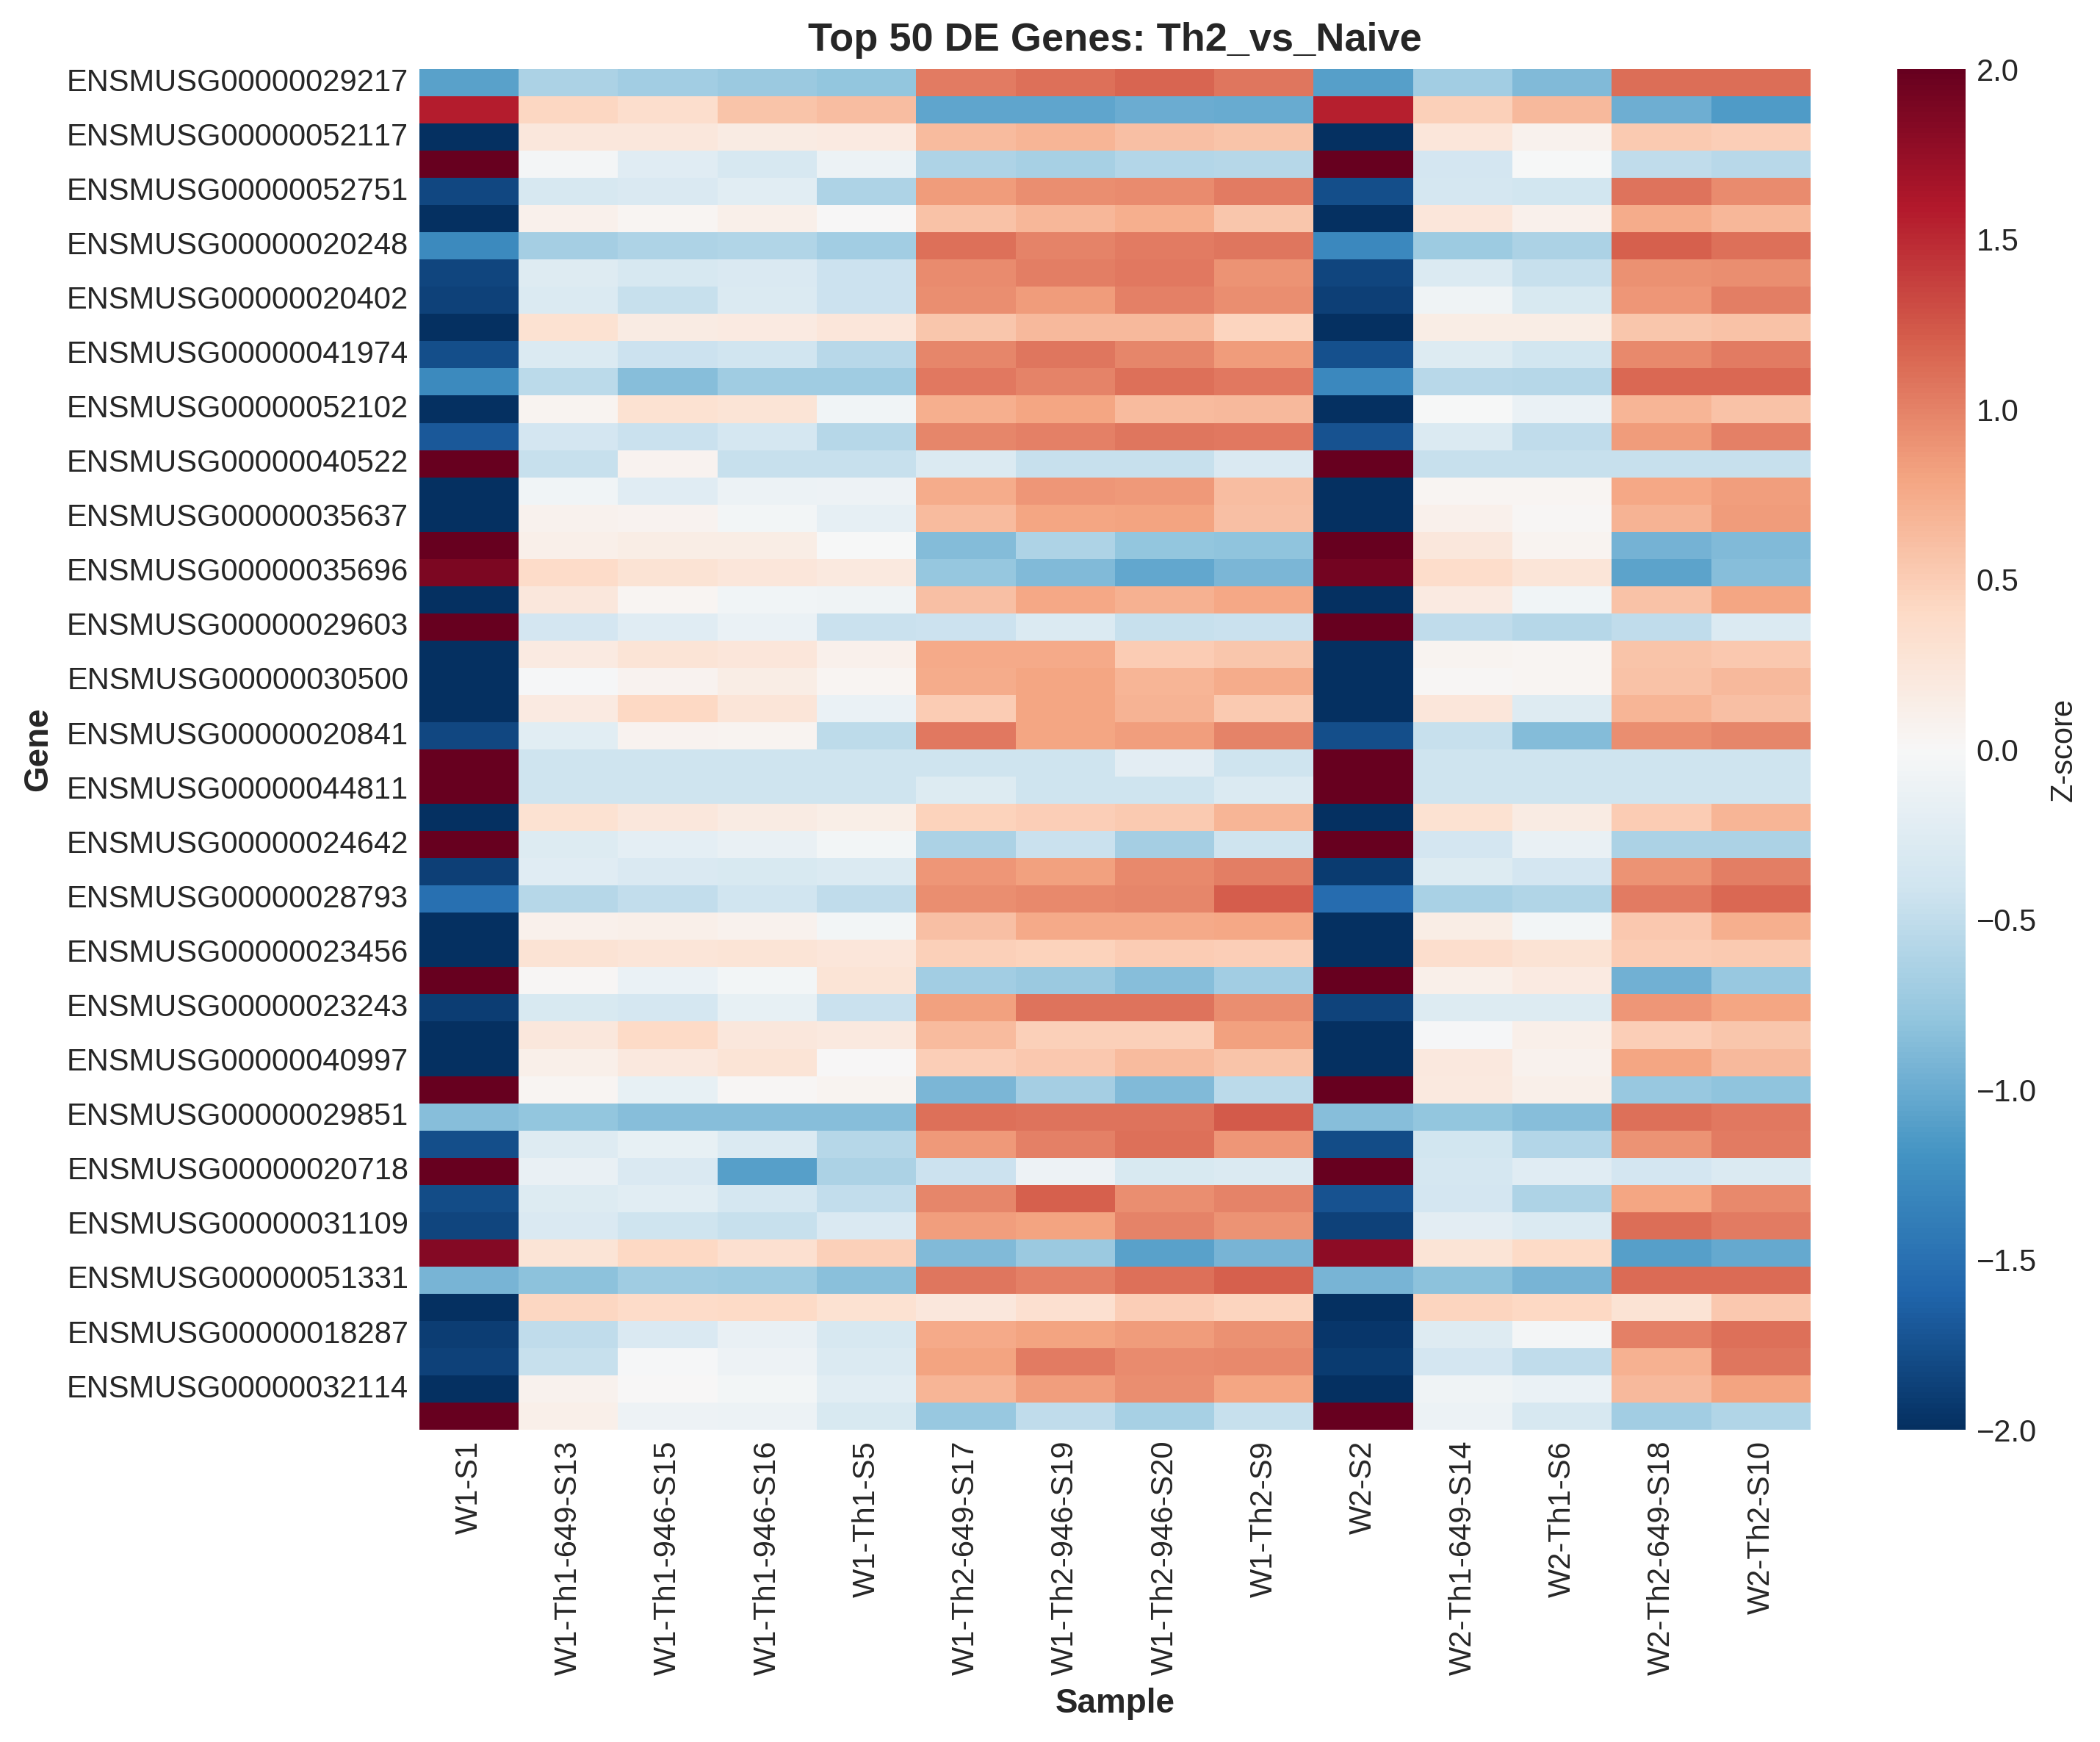

In [19]:
import glob
from IPython.display import Image, display

for f in sorted(glob.glob("gse123966_results/*.png")):
    print(f"\n=== {f} ===")
    display(Image(filename=f))


In [20]:
import shutil
from google.colab import files

shutil.make_archive('gse123966_results', 'zip', 'gse123966_results')
files.download('gse123966_results.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>